# Experiment  0: ToM Overall Model Performance


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pymc
import networkx as nx
import matplotlib.pyplot as plt
import random
import torch

In [3]:
import sys
import os
import osmnx as ox

# Adjust this path as needed to point to your project root
sys.path.append(os.path.abspath(".."))

In [4]:
def plot_goal_distribution(goal_distribution):
    """
    Plot the goal distribution as a bar plot.

    Parameters
    ----------
    goal_distribution : dict
        Dictionary mapping candidate goal IDs to probability values.
    """
    # Extract goal IDs and probabilities, converting to floats if needed.
    goals = list(goal_distribution.keys())
    probs = [float(goal_distribution[g]) for g in goals]
    
    # Create the bar plot.
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(goals)), probs, tick_label=[str(g) for g in goals])
    plt.xlabel("Candidate Goal IDs")
    plt.ylabel("Probability")
    plt.title("Posterior Distribution over Candidate Goals")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

In [5]:
def visualize_map(campus,
                  path=None,
                  goal_nodes=None,
                  ax=None):
    """
    Visualize the campus map, plus optional trajectory, start, waypoint, and goal nodes.
    
    Arguments:
      campus         an object with:
                        - campus.G           : a networkx graph
                        - campus.node_coords : dict[node] -> (x, y) coordinates
                        - campus.buildings   : a GeoDataFrame of building footprints (or None)
      path           list of node‐IDs, the agent’s trajectory to draw (in order)
      start_nodes    list of node‐IDs to mark as start(s)
      waypoint       single node‐ID to mark as an intermediate waypoint
      goal_nodes     list of node‐IDs to mark as goal(s)
      ax             optional matplotlib Axes onto which to draw
      
    Returns:
      fig, ax        the figure & axis
    """
    # 1) draw the base map
    if ax is None:
        fig, ax = ox.plot_graph(campus.G,
                                figsize=(15,15),
                                node_size=5,
                                edge_color="#999999",
                                show=False,
                                close=False)
    else:
        fig = ax.figure
        ox.plot_graph(campus.G,
                      ax=ax,
                      node_size=5,
                      edge_color="#999999",
                      show=False)
    
    # 2) overlay buildings if you have them
    if getattr(campus, "buildings", None) is not None:
        campus.buildings.plot(ax=ax,
                              color="#bbbbbb",
                              alpha=0.7,
                              edgecolor="#444444")
    
    # 3) draw the agent’s path
    if path is not None and len(path) > 1:
        coords = [campus.node_coords[n] for n in path]
        xs, ys = zip(*coords)
        ax.plot(xs, ys,
                linestyle='-',
                linewidth=3.0,
                color='lightblue',
                alpha=0.8,
                zorder=3,
                label="Trajectory")
        # and mark the actual visited nodes
        ax.scatter(xs, ys,
                   c='C0',
                   s=30,
                   zorder=4)
    
    # 6) mark goal nodes
    if goal_nodes:
        goal_coords = [campus.node_coords[n] for n in goal_nodes]
        xs, ys = zip(*goal_coords)
        ax.scatter(xs, ys,
                   c="yellow",
                   s=160,
                   marker="*",
                   zorder=5,
                   label="Goal")
    
    # 7) finalize
    ax.legend(loc="upper right")
    ax.set_title("UCSD Campus Environment")
    ax.set_axis_off()
    fig.tight_layout()
    return fig, ax

In [6]:
from real_world_src.environment.campus_env import CampusEnvironment
from real_world_src.agents.agent_factory import AgentFactory
from real_world_src.simulation.simulator import Simulator
#from real_world_src.simulation.experiment_1 import Simulator

from real_world_src.utils.run_manager import RunManager
from real_world_src.utils.config import VISUAL_CONFIG
from real_world_src.utils.config import get_agent_color


## Steps  
1. Create the UCSD campus world
2. Create n agents each with a specific distribution over the goals
3. Run m epsiodes where each agent chooses a goal and performs a single path to that goal
4. Use this data as training set

## Step 1: Create the Map

In [7]:
# Create a run manager
# run_manager = RunManager('visuals')
# run_dir = run_manager.start_new_run()

# Initialize campus environment
campus = CampusEnvironment()

Loading graph from ucsd_campus.graphml...
Environment loaded with 3151 nodes and 8746 edges


## Step 2: Create N Agents

In [8]:
# Need to establish the set of common goals (just choose the landmark nodes)
goals = [469084068, 49150691, 768264666, 1926666015, 1926673385, 49309735,
         273627682, 445989107, 445992528, 446128310, 1772230346, 1926673336, 
         2872424923, 3139419286, 4037576308]

## Step 3: Perform Episodes and Data Collection

In [9]:
import json

### Load existing data

In [10]:
import json, pickle

with open("./data/data/1k/path_data.json", 'r') as file:
    path_data = json.load(file)

with open("./data/data/1k/goal_data.json", 'r') as file:
    goal_data = json.load(file)

with open('./data/data/1k/agents.pkl', 'rb') as f:
    agents = pickle.load(f)

/var/folders/38/k8ptv94x02v3qc6vywd5sfv40000gn/T/ipykernel_19272/1256136615.py:10: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  agents = pickle.load(f)


In [11]:
def convert_keys_to_int(data):
    if isinstance(data, dict):
        return {int(k) if isinstance(k, str) and k.isdigit() else k: convert_keys_to_int(v) for k, v in data.items()}
    elif isinstance(data, list):
        return [convert_keys_to_int(item) for item in data]
    else:
        return data

In [12]:
goal_data = convert_keys_to_int(goal_data)
path_data = convert_keys_to_int(path_data)

## Step 4: Fit the Models
There should again be a dict of dict for posteriors. The first key will be for the episode, the second key will be the agent, and the value of this will be a list of dicts for the posteriors. 

In [13]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda:1")
else:
    device = torch.device("cpu")

### BToM

In [14]:
with open("./data/data/data_utils/btom_posteriors.json", 'r') as file:
    posteriors_data = json.load(file)

### Extended BToM

In [15]:
with open("./data/data/data_utils/ext_btom_posteriors.json", 'r') as file:
    ext_posteriors_data = json.load(file)

# To get posterior data

In [16]:
n_test = int(0.2 * len(agents))
test_agent_ids = [agent.id for agent in agents[-n_test:]]

### LSTM

In [17]:
# Import LSTM model and helpers
from real_world_src.models.lstm import (
    SimpleLSTM, LSTMDataset, lstm_collate_fn,
    train_lstm_model, evaluate_lstm_model, predict_goal_posterior
)
from torch.utils.data import DataLoader

In [18]:
# build node2idx so that every node in campus.G_undirected maps to 0…V−1
all_nodes = list(campus.G_undirected.nodes())
node2idx  = {n:i for i,n in enumerate(all_nodes)}
V = len(all_nodes)

# build goal2idx likewise for your goals list
goal2idx = {g:i for i,g in enumerate(goals)}
G = len(goals)

In [19]:
# load the lstm posteriors json file
with open("./data/data/data_utils/lstm_posteriors.json", 'r') as file:
    lstm_posteriors = json.load(file)

### GRU

In [20]:
from real_world_src.models.gru import (
    SimpleGRU, GRUDataset, gru_collate_fn,
    train_gru_model, evaluate_gru_model, predict_goal_posterior_gru
)
from torch.utils.data import DataLoader

In [21]:
# load the gru posteriors json file
with open("./data/data/data_utils/gru_posteriors.json", 'r') as file:
    gru_posteriors = json.load(file)

### ToMNet

In [22]:
from real_world_src.models.tomnet import ToMNet, ToMNetDataset, tomnet_collate_fn, infer_goal_dists
from torch.utils.data import Dataset, DataLoader


In [70]:
def get_posterior_format(dists):
    idx2goal = { idx: goal for goal, idx in goal2idx.items() }
    goal_posterior = [ {idx2goal[i]: float(p) for i, p in enumerate(prob_row) } for prob_row in dists]
    return goal_posterior

In [71]:
# build node2idx so that every node in campus.G_undirected maps to 0…V−1
all_nodes = set()
for episode in path_data.values():
    for path in episode.values():
        if isinstance(path, (list, tuple, set)):
            all_nodes.update(path)
        else:
            all_nodes.add(path)
all_nodes.update(campus.G_undirected.nodes())
all_nodes = list(all_nodes)

node2idx = {n: i for i, n in enumerate(all_nodes)}
print(f"Number of nodes in node2idx: {len(node2idx)}")

V = len(all_nodes)

# build goal2idx likewise for your goals list
goal2idx = {g:i for i,g in enumerate(goals)}
G = len(goals)

Number of nodes in node2idx: 3185


In [72]:
all_nodes = set()
for episode in path_data.values():
    for path in episode.values():
        if isinstance(path, (list, tuple, set)):
            all_nodes.update(path)
        else:
            all_nodes.add(path)
all_nodes.update(campus.G_undirected.nodes())
all_nodes = list(all_nodes)
node2idx = {n: i for i, n in enumerate(all_nodes)}
print(f"Number of nodes in node2idx: {len(node2idx)}")

Number of nodes in node2idx: 3185


Getting posteriors for test data

In [73]:
n_test = int(0.2 * len(agents))
test_agent_ids = [agent.id for agent in agents[-n_test:]]

In [23]:
with open("./data/data/data_utils/tomnet_posteriors.json", 'r') as file:
    tomnet_posteriors = json.load(file)

In [24]:
# print device type and the name of the gpu
device = torch.device("cpu")

print(f"Device type: {device.type}, Device name: {torch.cuda.get_device_name(0) if device.type == 'cuda' else 'N/A'}")

Device type: cpu, Device name: N/A


### SOTA: Our Model

In [36]:
# Import our novel SOTA model components
from real_world_src.models.tomnet_causal_trainer import TomNetCausal, train_pipeline
from real_world_src.models.tomnet_causal_dataloader import CampusDataLoader
import torch
import torch.nn.functional as F
from tqdm import tqdm

In [91]:
# Check if node mapping exists, if not create it first
node_mapping_path = "./data/data/1k/node_mapping_3185.pkl"
if not os.path.exists(node_mapping_path):
    print("Node mapping not found. Creating it first...")
    # Initialize data loader in train mode to create the mapping
    data_loader_train = CampusDataLoader(
        data_dir="./data/data/1k/",
        node_mapping_path=None,
        save_node_mapping_path=node_mapping_path,
        mode='train'
    )
    print("Node mapping created successfully!")

# Now initialize data loader for evaluation
print("Initializing CampusDataLoader for TomNetCausal evaluation...")
data_loader = CampusDataLoader(
    data_dir="./data/data/1k/",
    node_mapping_path=node_mapping_path,
    save_node_mapping_path=node_mapping_path,
    mode='eval'
)

Initializing CampusDataLoader for TomNetCausal evaluation...
Loading campus environment...
Loading graph from ucsd_campus.graphml...
Environment loaded with 3151 nodes and 8746 edges
Loading agents...
Loaded 100 agents
Loading path data...
Path data keys: 1000
Loading goal data...
Goal data keys: 1000
Loading node_id_mapping from ./data/data/1k/node_mapping_3185.pkl
Loaded node_id_mapping with 3185 nodes.
[EVAL] Using fixed node_id_mapping with 3185 nodes.
Node ID range: 48865150 to 13015886764
Sequential range: 0 to 3184


In [92]:
# Get data dimensions
path_data_causal = data_loader.path_data
goal_data_causal = data_loader.goal_data
node_id_mapping = data_loader.node_id_mapping
num_nodes = len(node_id_mapping)
print(f"Number of nodes: {num_nodes}")

# Prepare graph data
print("Preparing graph data...")
graph_data = data_loader.prepare_graph_data(
    save_cuda_path='./data/data/1k/graph_data_cuda.pt',
    device=device
)

Number of nodes: 3185
Preparing graph data...


In [93]:
# filepath: /root/Theory-of-mind/notebooks/Campus_Experiment_0.ipynb
print("Initializing TomNetCausal model...")
num_nodes = len(node_id_mapping)  # Should be 3185 for your checkpoint!
print(f"num_nodes for model: {num_nodes}")
model = TomNetCausal(
    node_feat_dim=4,
    num_nodes=num_nodes,
    time_emb_dim=16,
    hidden_dim=128,
    latent_dim=32,
    n_layers=2,
    n_heads=4,
    dropout=0.1,
    use_gat=True
).to(device)

Initializing TomNetCausal model...
num_nodes for model: 3185


In [98]:
model_path = "./data/trained_models/new_node_mapped_tomnet_causal_model_1k_3185.pth"
if os.path.exists(model_path):
    print(f"Loading pre-trained model from {model_path}")
else:
    print("sorry")

Loading pre-trained model from ./data/trained_models/new_node_mapped_tomnet_causal_model_1k_3185.pth


In [100]:
model_path = "./data/trained_models/new_node_mapped_tomnet_causal_model_1k_3185.pth"
if os.path.exists(model_path):
    print(f"Loading pre-trained model from {model_path}")
    checkpoint = torch.load(model_path, map_location=device)
    # Try loading with strict=False to skip mismatched layers
    missing, unexpected = model.load_state_dict(checkpoint, strict=False)
    if missing:
        print("WARNING: Missing keys in state_dict:", missing)
    if unexpected:
        print("WARNING: Unexpected keys in state_dict:", unexpected)
    model.eval()
else:
    print("No pre-trained model found. Training from scratch...")
    # Train the model using the pipeline
    train_pipeline(
        epochs=10,
        batch_size=2048,
        log_wandb=False,
        max_seq_len=100,
        top_k=5,
        gpu=1 if torch.cuda.is_available() else None,
        data_dir="./data/data/1k/",
        node_mapping_path=node_mapping_path,
        save_node_mapping_path=node_mapping_path,
        save_model=True,
        model_save_name="new_node_mapped_tomnet_causal_model_1k_3185"
    )

Loading pre-trained model from ./data/trained_models/new_node_mapped_tomnet_causal_model_1k_3185.pth


In [101]:
# --- Posterior calculator for TomNetCausal (SOTA) model ---
from tqdm import tqdm

def get_tomnet_causal_posterior_format(dists, goals):
    """
    Convert list of posterior arrays to list of {goal: prob} dicts.
    """
    return [
        {goal: float(prob[i]) for i, goal in enumerate(goals)}
        for prob in dists
    ]

def infer_tomnet_causal_goal_dists(
    model, agent_id, episode, path_data, node_id_mapping, goals, graph_data, max_seq_len=100, device='cpu'
):
    """
    Compute posteriors for each prefix of the agent's path in the given episode.
    Returns a list of arrays (one per prefix), each array is [num_goals] (ordered as in `goals`).
    """
    model.eval()
    if agent_id not in path_data.get(episode, {}):
        return []
    path = path_data[episode][agent_id]
    valid_path = [n for n in path if n in node_id_mapping]
    if len(valid_path) < 2:
        return []
    dists = []
    with torch.no_grad():
        for t in range(1, min(len(valid_path)+1, max_seq_len+1)):
            partial_path = valid_path[:t]
            path_indices = [node_id_mapping[n] for n in partial_path]
            # Pad to max_seq_len
            if len(path_indices) < max_seq_len:
                path_indices = path_indices + [0] * (max_seq_len - len(path_indices))
            trajectory_data = {
                'node_ids': torch.tensor([path_indices], dtype=torch.long).to(device),
                'timestamps': torch.arange(len(path_indices), dtype=torch.float).unsqueeze(0).to(device),
                'mask': torch.ones(1, len(path_indices), dtype=torch.bool).to(device)
            }
            latents, fused, logits = model(trajectory_data, graph_data)
            probs = torch.softmax(logits, dim=-1)
            # Extract probabilities for the goal nodes in order
            goal_probs = []
            for goal in goals:
                if goal in node_id_mapping:
                    goal_idx = node_id_mapping[goal]
                    if goal_idx < probs.shape[1]:
                        goal_probs.append(float(probs[0, goal_idx]))
                    else:
                        goal_probs.append(0.0)
                else:
                    goal_probs.append(0.0)
            dists.append(goal_probs)
    return dists


In [102]:
tomnet_causal_posteriors = {}

# Ensure graph_data is on the correct device
if hasattr(graph_data, 'to'):
    graph_data = graph_data.to(device)
elif isinstance(graph_data, dict):
    graph_data = {k: v.to(device) if hasattr(v, 'to') else v for k, v in graph_data.items()}

print(f"Model device: {next(model.parameters()).device}")
print(f"Graph data device: {graph_data['x'].device if 'x' in graph_data else 'No x in graph_data'}")

for episode in tqdm(range(len(goal_data)), desc="TomNetCausal Episode"):
    episode_str = str(episode)  # Convert to string to match path_data_causal keys
    tomnet_causal_posteriors[episode] = {}
    for agent in agents:
        if agent.id not in test_agent_ids:
            continue
        
        # Convert agent.id to string to match path_data_causal structure
        agent_id_str = str(agent.id)
        
        dists = infer_tomnet_causal_goal_dists(
            model, agent_id_str, episode_str, path_data_causal, node_id_mapping, goals, graph_data, max_seq_len=100, device=device
        )
        if dists:
            tomnet_causal_posteriors[episode][agent.id] = get_tomnet_causal_posterior_format(dists, goals)

Model device: cpu
Graph data device: cpu


TomNetCausal Episode:   0%|          | 1/1000 [00:10<2:47:03, 10.03s/it]


KeyboardInterrupt: 

In [104]:
print("=== TOMNET_CAUSAL_POSTERIORS STATUS ===")
print(f"Total episodes: {len(tomnet_causal_posteriors)}")
print(f"Total entries: {sum(len(v) for v in tomnet_causal_posteriors.values())}")

# Show structure for first few episodes
for episode in list(tomnet_causal_posteriors.keys())[:3]:
    agents_in_episode = list(tomnet_causal_posteriors[episode].keys())
    print(f"Episode {episode}: {len(agents_in_episode)} agents")
    if agents_in_episode:
        first_agent = agents_in_episode[0]
        posteriors = tomnet_causal_posteriors[episode][first_agent]
        print(f"  Agent {first_agent}: {len(posteriors)} time steps")
        if posteriors:
            print(f"  Sample posterior at t=0: {list(posteriors[0].keys())[:3]}...")

print(f"\nComparison with tomnet_posteriors:")
print(f"tomnet_posteriors total entries: {sum(len(v) for v in tomnet_posteriors.values()) if tomnet_posteriors else 0}")

print("\n=== SUCCESS! tomnet_causal_posteriors is now populated! ===")

=== TOMNET_CAUSAL_POSTERIORS STATUS ===
Total episodes: 1000
Total entries: 20000
Episode 0: 20 agents
  Agent 80: 28 time steps
  Sample posterior at t=0: ['469084068', '49150691', '768264666']...
Episode 1: 20 agents
  Agent 80: 39 time steps
  Sample posterior at t=0: ['469084068', '49150691', '768264666']...
Episode 2: 20 agents
  Agent 80: 35 time steps
  Sample posterior at t=0: ['469084068', '49150691', '768264666']...

Comparison with tomnet_posteriors:
tomnet_posteriors total entries: 20000

=== SUCCESS! tomnet_causal_posteriors is now populated! ===


In [25]:
with open("./data/data/data_utils/tomnet_causal_posteriors.json", "r") as f:
    tomnet_causal_posteriors = json.load(f)

In [26]:
print(tomnet_causal_posteriors['0'])

{'80': [{'469084068': 0.0, '49150691': 0.0, '768264666': 1.4881230812716584e-26, '1926666015': 4.716910760763767e-41, '1926673385': 1.2047626370586956e-22, '49309735': 2.3541814200656927e-43, '273627682': 0.0, '445989107': 0.0, '445992528': 0.0, '446128310': 2.1609203305290447e-29, '1772230346': 1.276555818857856e-24, '1926673336': 4.308863723815442e-36, '2872424923': 1.1388926893471462e-32, '3139419286': 3.566030444010447e-30, '4037576308': 4.031527680581348e-07}, {'469084068': 0.0, '49150691': 0.0, '768264666': 1.1954427431854368e-26, '1926666015': 3.144934143484187e-41, '1926673385': 9.619532699155856e-23, '49309735': 1.7796490496925177e-43, '273627682': 0.0, '445989107': 0.0, '445992528': 0.0, '446128310': 1.8353751258145785e-29, '1772230346': 8.857795671755601e-25, '1926673336': 3.116486349728766e-36, '2872424923': 7.760109710925827e-33, '3139419286': 2.9137947081177118e-30, '4037576308': 3.9200651258397556e-07}, {'469084068': 0.0, '49150691': 0.0, '768264666': 9.534232219143436e-

## Step 5: Visualizing Performance for Experiment 0  
We want to visualize the average brier score across all agents for all epsiodes. That is, calculate the brier score for every path and then take the average. Plot this as a line.

In [27]:
from real_world_src.utils.metrics import brier_along_path, accuracy_along_path

In [28]:
# # BToM Scores (robust: only agents with posteriors, and matching path/posterior lengths)
# scores = []
# for episode in range(len(goal_data)):
#     episode_str = str(episode)  # Convert to string to match posteriors_data keys
#     for agent in agents:
#         if episode_str not in posteriors_data or agent.id not in posteriors_data[episode_str]:
#             continue  # skip agents with no posteriors
#         path = path_data[episode][agent.id]
#         posteriors = posteriors_data[episode_str][agent.id]
#         min_len = min(len(path), len(posteriors))
#         if min_len == 0:
#             continue  # skip empty paths/posteriors
#         scores.append(brier_along_path(
#             path[:min_len],
#             goal_data[episode][agent.id],
#             posteriors[:min_len],
#             goals
#         ))

In [29]:
"""# BToM Scores
scores = []
for episode in range(len(goal_data)):
    for agent in agents:
        scores.append(brier_along_path(path_data[episode][agent.id], 
                                  goal_data[episode][agent.id], 
                                  posteriors_data[episode][agent.id], 
                                  goals))
                                  """

'# BToM Scores\nscores = []\nfor episode in range(len(goal_data)):\n    for agent in agents:\n        scores.append(brier_along_path(path_data[episode][agent.id], \n                                  goal_data[episode][agent.id], \n                                  posteriors_data[episode][agent.id], \n                                  goals))\n                                  '

In [30]:
# BToM Scores
# BToM Scores (robust: only agents with posteriors, and matching path/posterior lengths)
scores = []
for episode in range(len(goal_data)):
    episode_str = str(episode)  # Convert to string to match posteriors_data keys
    for agent in agents:
        agent_id_str = str(agent.id)  # Convert agent.id to string
        if episode_str not in posteriors_data or agent_id_str not in posteriors_data[episode_str]:
            continue  # skip agents with no posteriors
        path = path_data[episode][agent.id]
        posteriors = posteriors_data[episode_str][agent_id_str]
        min_len = min(len(path), len(posteriors))
        if min_len == 0:
            continue  # skip empty paths/posteriors
        scores.append(brier_along_path(
            path[:min_len],
            goal_data[episode][agent.id],
            posteriors[:min_len],
            goals
        ))
        
# Extended BToM Scores
ext_scores = []
for episode in range(len(goal_data)):
    episode_str = str(episode)  # Convert to string to match ext_posteriors_data keys
    for agent in agents:
        agent_id_str = str(agent.id)  # Convert agent.id to string
        if episode_str not in ext_posteriors_data or agent_id_str not in ext_posteriors_data[episode_str]:
            continue
        path = path_data[episode][agent.id]
        posteriors = ext_posteriors_data[episode_str][agent_id_str]
        min_len = min(len(path), len(posteriors))
        if min_len == 0:
            continue
        ext_scores.append(brier_along_path(
            path[:min_len],
            goal_data[episode][agent.id],
            posteriors[:min_len],
            goals
        ))

# ToMNet Scores
tomnet_scores = []
for episode in range(len(goal_data)):
    episode_str = str(episode)  # Convert to string to match tomnet_posteriors keys
    for agent in agents:
        if agent.id not in test_agent_ids:
            continue
        agent_id_str = str(agent.id)  # Convert agent.id to string
        if episode_str not in tomnet_posteriors or agent_id_str not in tomnet_posteriors[episode_str]:
            continue
        tomnet_scores.append(brier_along_path(path_data[episode][agent.id], 
                                  goal_data[episode][agent.id], 
                                  tomnet_posteriors[episode_str][agent_id_str], 
                                  goals))


In [31]:
print(ext_scores[1:5])

[[0.9333333333333336, 0.07787651411540823, 0.8628284156055573, 0.08223803554128127, 0.10412552504025342, 0.13258823847813997, 0.13824091141359612, 0.2628441174484605, 0.2630661060871825, 0.21259524279435554, 0.5139539958646056], [0.9333333333333336, 0.10989993994790714, 0.20022371192455438, 0.2294809128759533, 0.46048966221632176, 0.0667680175460886, 0.28521812506801514, 0.37557609995434776, 0.471465457494272, 0.08120481002071543, 0.7102276968845702], [0.9333333333333335, 0.1315275800836506, 0.1366192154384961, 0.1688288769509885, 0.9080597869476432, 0.252071012854648, 0.7600225216625309, 0.4990718796522553, 0.49636178184951685, 0.5467128911762721, 0.06666666666666667], [0.9333333333333338, 0.07858618686693775, 0.12310629716707347, 0.1317976559900489, 0.23194517509769894, 0.10557611450192338, 0.1494900849009768, 0.07637894652839573, 0.6676389893689872, 0.9835722669874614, 0.9990506693385249]]


In [32]:
# TomNetCausal Scores
tomnet_causal_scores = []
for episode in range(len(goal_data)):
    episode_str = str(episode)  # Convert to string to match tomnet_causal_posteriors keys
    for agent in agents:
        if agent.id not in test_agent_ids:
            continue
        agent_id_str = str(agent.id)  # Convert agent.id to string
        if episode_str not in tomnet_causal_posteriors or agent_id_str not in tomnet_causal_posteriors[episode_str]:
            continue
        tomnet_causal_scores.append(brier_along_path(
            path_data[episode][agent.id],
            goal_data[episode][agent.id],
            tomnet_causal_posteriors[episode_str][agent_id_str],
            goals
        ))


In [33]:
# LSTM Scores
lstm_scores = []
for episode in range(len(goal_data)):
    episode_str = str(episode)  # Convert to string to match lstm_posteriors keys
    for agent in agents:
        if agent.id not in test_agent_ids:
            continue
        agent_id_str = str(agent.id)  # Convert agent.id to string
        if episode_str not in lstm_posteriors or agent_id_str not in lstm_posteriors[episode_str]:
            continue
        path = path_data[episode][agent.id]
        posteriors = lstm_posteriors[episode_str][agent_id_str]
        min_len = min(len(path), len(posteriors))
        if min_len == 0:
            continue
        lstm_scores.append(brier_along_path(
            path[:min_len],
            goal_data[episode][agent.id],
            posteriors[:min_len],
            goals
        ))

# Plotting LSTM scores
#props = np.linspace(0.1, 1.0, num=10)
#props = np.linspace(0, 1, arr.shape[1])
#lstm_arr = np.array(lstm_scores)
#mean_lstm = lstm_arr.mean(axis=0)
#plt.plot(props, mean_lstm, '-o', label='LSTM')
#plt.legend()

In [34]:
# GRU Scores
gru_scores = []
for episode in range(len(goal_data)):
    episode_str = str(episode)  # Convert to string to match gru_posteriors keys
    for agent in agents:
        if agent.id not in test_agent_ids:
            continue
        agent_id_str = str(agent.id)  # Convert agent.id to string
        if episode_str not in gru_posteriors or agent_id_str not in gru_posteriors[episode_str]:
            continue
        path = path_data[episode][agent.id]
        posteriors = gru_posteriors[episode_str][agent_id_str]
        min_len = min(len(path), len(posteriors))
        if min_len == 0:
            continue
        gru_scores.append(brier_along_path(
            path[:min_len],
            goal_data[episode][agent.id],
            posteriors[:min_len],
            goals
        ))

In [38]:
# BToM Accuracy Scores (robust: trim path and posteriors to same length)
btom_acc = []
for episode in tqdm(range(len(goal_data)), desc="Episodes"):
    episode_str = str(episode)  # Convert to string to match posteriors_data keys
    for agent in agents:
        agent_id_str = str(agent.id)  # Convert agent.id to string
        if episode_str not in posteriors_data or agent_id_str not in posteriors_data[episode_str]:
            continue
        path = path_data[episode][agent.id]
        posteriors = posteriors_data[episode_str][agent_id_str]
        min_len = min(len(path), len(posteriors))
        if min_len == 0:
            continue
        btom_acc.append(accuracy_along_path(
            path[:min_len],
            goal_data[episode][agent.id],
            posteriors[:min_len],
            goals
        ))


Episodes: 100%|██████████| 1000/1000 [00:01<00:00, 594.75it/s]


In [39]:
# Extended BToM Scores
ext_acc = []
for episode in tqdm(range(len(goal_data)), desc="Episodes"):
    episode_str = str(episode)  # Convert to string to match ext_posteriors_data keys
    for agent in agents:
        agent_id_str = str(agent.id)  # Convert agent.id to string
        if episode_str not in ext_posteriors_data or agent_id_str not in ext_posteriors_data[episode_str]:
            continue
        path = path_data[episode][agent.id]
        posteriors = ext_posteriors_data[episode_str][agent_id_str]
        min_len = min(len(path), len(posteriors))
        if min_len == 0:
            continue
        ext_acc.append(accuracy_along_path(
            path[:min_len],
            goal_data[episode][agent.id],
            posteriors[:min_len],
            goals
        ))

# ToMNet Scores
tomnet_acc = []
for episode in tqdm(range(len(goal_data)), desc="Episodes"):
    episode_str = str(episode)  # Convert to string to match tomnet_posteriors keys
    for agent in agents:
        if agent.id not in test_agent_ids:
            continue
        agent_id_str = str(agent.id)  # Convert agent.id to string
        if episode_str not in tomnet_posteriors or agent_id_str not in tomnet_posteriors[episode_str]:
            continue
        path = path_data[episode][agent.id]
        posteriors = tomnet_posteriors[episode_str][agent_id_str]
        min_len = min(len(path), len(posteriors))
        if min_len == 0:
            continue
        tomnet_acc.append(accuracy_along_path(
            path[:min_len],
            goal_data[episode][agent.id],
            posteriors[:min_len],
            goals
        ))

Episodes: 100%|██████████| 1000/1000 [00:00<00:00, 2863.52it/s]


In [133]:
goals

[469084068,
 49150691,
 768264666,
 1926666015,
 1926673385,
 49309735,
 273627682,
 445989107,
 445992528,
 446128310,
 1772230346,
 1926673336,
 2872424923,
 3139419286,
 4037576308]

In [40]:
# LSTM accuracy scores
lstm_acc = []
for episode in tqdm(range(len(goal_data))):
    episode_str = str(episode)  # Convert to string to match lstm_posteriors keys
    for agent in agents:
        if agent.id not in test_agent_ids:
            continue
        agent_id_str = str(agent.id)  # Convert agent.id to string
        if episode_str not in lstm_posteriors or agent_id_str not in lstm_posteriors[episode_str]:
            continue
        path = path_data[episode][agent.id]
        posteriors = lstm_posteriors[episode_str][agent_id_str]
        min_len = min(len(path), len(posteriors))
        if min_len == 0:
            continue
        lstm_acc.append(accuracy_along_path(
            path[:min_len],
            goal_data[episode][agent.id],
            posteriors[:min_len],
            goals
        ))

100%|██████████| 1000/1000 [00:00<00:00, 2848.44it/s]


In [71]:
# GRU accuracy scores
gru_acc = []
for episode in range(len(goal_data)):
    episode_str = str(episode)  # Convert to string to match gru_posteriors keys
    for agent in agents:
        if agent.id not in test_agent_ids:
            continue
        agent_id_str = str(agent.id)  # Convert agent.id to string
        if episode_str not in gru_posteriors or agent_id_str not in gru_posteriors[episode_str]:
            continue
        path = path_data[episode][agent.id]
        posteriors = gru_posteriors[episode_str][agent_id_str]
        min_len = min(len(path), len(posteriors))
        if min_len == 0:
            continue
        gru_acc.append(accuracy_along_path(
            path[:min_len],
            goal_data[episode][agent.id],
            posteriors[:min_len],
            goals
        ))


In [84]:
# TomNetCausal accuracy scores
tomnet_causal_acc = []
for episode in range(len(goal_data)):
    episode_str = str(episode)  # Convert to string to match tomnet_causal_posteriors keys
    i = 0
    for agent in agents:
        if agent.id not in test_agent_ids:
            continue
        agent_id_str = str(agent.id)  # Convert agent.id to string
        if episode_str not in tomnet_causal_posteriors or agent_id_str not in tomnet_causal_posteriors[episode_str]:
            continue
        path = path_data[episode][agent.id]
        posteriors = tomnet_causal_posteriors[episode_str][agent_id_str]
        min_len = min(len(path), len(posteriors))
        if min_len == 0:
            continue
        tomnet_causal_acc.append(accuracy_along_path(
            path[:min_len],
            goal_data[episode][agent.id],
            posteriors[:min_len],
            goals
        ))

        if i == 50:
            true_goal = goal_data[episode][agent.id]
            print("True Goal: {}".format(true_goal))
            for post in posteriors[:min_len]:
                print(max(post, key=post.get))
            break
        i+=1
    

In [65]:
true_goal = str(goal_data[episode][agent.id])
print("True Goal: {}".format(true_goal))
for post in posteriors[:min_len]:
    print(max(post, key=post.get))

True Goal: 3139419286
4037576308
4037576308
4037576308
4037576308
4037576308
4037576308
4037576308
4037576308
4037576308
4037576308
4037576308
4037576308
4037576308
4037576308
4037576308
4037576308
4037576308
4037576308
4037576308
4037576308
4037576308
4037576308
4037576308
4037576308
4037576308
4037576308
4037576308
4037576308
4037576308
4037576308
4037576308
4037576308
4037576308
4037576308
4037576308
4037576308
4037576308
4037576308
4037576308
4037576308
4037576308
4037576308
4037576308
4037576308
4037576308
4037576308
4037576308
4037576308
4037576308
4037576308
4037576308
4037576308
4037576308
4037576308
4037576308
4037576308
4037576308
4037576308
4037576308
4037576308
4037576308
4037576308
4037576308
4037576308
4037576308
4037576308
4037576308
4037576308
4037576308
4037576308
4037576308
4037576308


=== DEBUGGING ARRAY SHAPES ===
scores length: 100000
ext_scores length: 100000
lstm_scores length: 20000
gru_scores length: 20000
tomnet_scores length: 20000
tomnet_causal_scores length: 20000
Sample scores[0] type: <class 'list'>, length: 11
Sample tomnet_causal_scores[0] type: <class 'list'>, length: 11

Array shapes:
arr (BToM): (100000, 11)
ext_arr: (100000, 11)
lstm_arr: (20000, 11)
gru_arr: (20000, 11)
tomnet_arr: (20000, 11)
tomnet_causal_arr: (20000, 11)


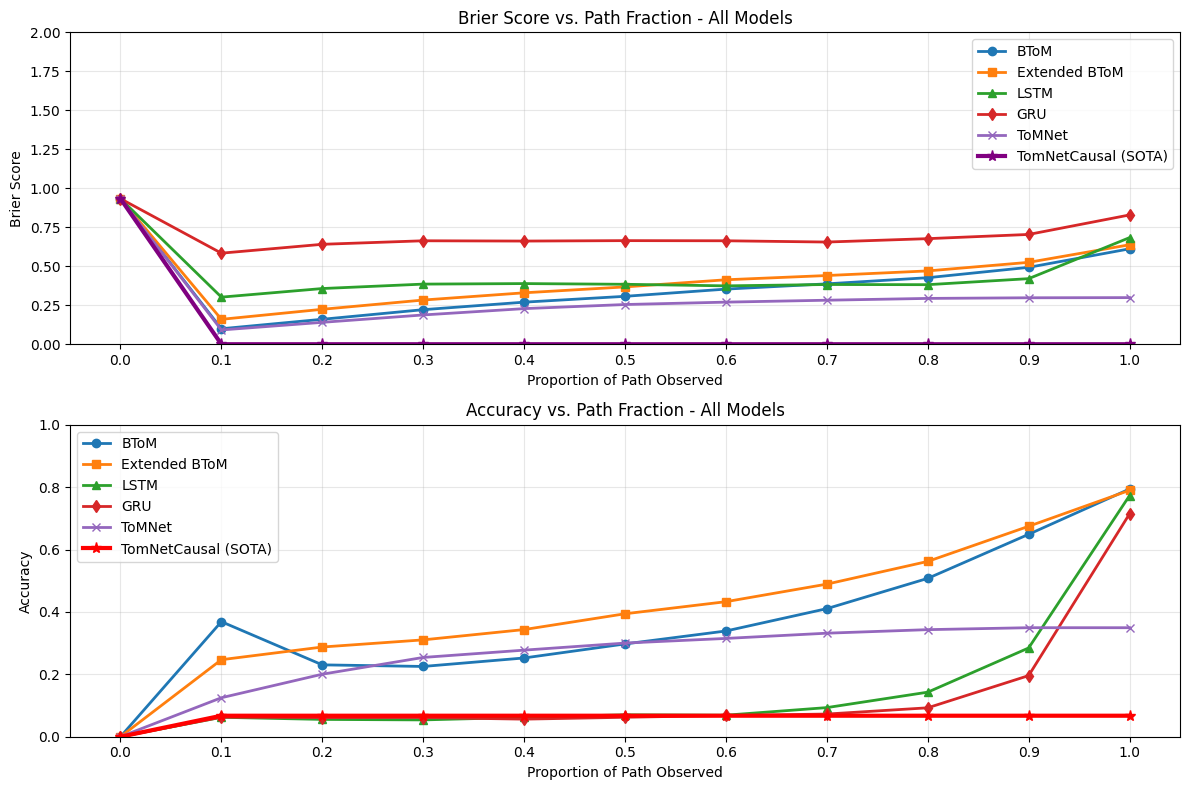

In [47]:
import numpy as np
import matplotlib.pyplot as plt

# Debug: Check the arrays before plotting
print("=== DEBUGGING ARRAY SHAPES ===")
print(f"scores length: {len(scores)}")
print(f"ext_scores length: {len(ext_scores)}")
print(f"lstm_scores length: {len(lstm_scores)}")
print(f"gru_scores length: {len(gru_scores)}")
print(f"tomnet_scores length: {len(tomnet_scores)}")
print(f"tomnet_causal_scores length: {len(tomnet_causal_scores)}")

# Check if any scores exist
if len(scores) > 0:
    print(f"Sample scores[0] type: {type(scores[0])}, length: {len(scores[0]) if hasattr(scores[0], '__len__') else 'scalar'}")
if len(tomnet_causal_scores) > 0:
    print(f"Sample tomnet_causal_scores[0] type: {type(tomnet_causal_scores[0])}, length: {len(tomnet_causal_scores[0]) if hasattr(tomnet_causal_scores[0], '__len__') else 'scalar'}")

# Only proceed if we have valid data
if len(scores) == 0:
    print("ERROR: No BToM scores found!")
if len(tomnet_causal_scores) == 0:
    print("ERROR: No TomNetCausal scores found!")

# Check if all arrays have consistent structure
all_arrays = [scores, ext_scores, lstm_scores, gru_scores, tomnet_scores, tomnet_causal_scores]
valid_arrays = [arr for arr in all_arrays if len(arr) > 0]

if not valid_arrays:
    print("ERROR: No valid score arrays found!")
else:
    # Convert to numpy arrays and check shapes
    try:
        arr = np.array(scores)  # shape (N, 11)
        ext_arr = np.array(ext_scores)
        lstm_arr = np.array(lstm_scores)
        gru_arr = np.array(gru_scores)
        tomnet_arr = np.array(tomnet_scores)
        tomnet_causal_arr = np.array(tomnet_causal_scores)
        
        print(f"\nArray shapes:")
        print(f"arr (BToM): {arr.shape}")
        print(f"ext_arr: {ext_arr.shape}")
        print(f"lstm_arr: {lstm_arr.shape}")
        print(f"gru_arr: {gru_arr.shape}")
        print(f"tomnet_arr: {tomnet_arr.shape}")
        print(f"tomnet_causal_arr: {tomnet_causal_arr.shape}")
        
        # Check if arrays are 2D
        valid_2d_arrays = []
        if arr.ndim == 2 and arr.shape[0] > 0:
            valid_2d_arrays.append(('BToM', arr))
        if ext_arr.ndim == 2 and ext_arr.shape[0] > 0:
            valid_2d_arrays.append(('Extended BToM', ext_arr))
        if lstm_arr.ndim == 2 and lstm_arr.shape[0] > 0:
            valid_2d_arrays.append(('LSTM', lstm_arr))
        if gru_arr.ndim == 2 and gru_arr.shape[0] > 0:
            valid_2d_arrays.append(('GRU', gru_arr))
        if tomnet_arr.ndim == 2 and tomnet_arr.shape[0] > 0:
            valid_2d_arrays.append(('ToMNet', tomnet_arr))
        if tomnet_causal_arr.ndim == 2 and tomnet_causal_arr.shape[0] > 0:
            valid_2d_arrays.append(('TomNetCausal', tomnet_causal_arr))
        
        if not valid_2d_arrays:
            print("ERROR: No valid 2D arrays found for plotting!")
        else:
            # Use the first valid array to determine the number of time steps
            _, reference_arr = valid_2d_arrays[0]
            props = np.linspace(0, 1, reference_arr.shape[1])
            
            plt.figure(figsize=(12, 8))
            
            # Brier Score Plot
            plt.subplot(2, 1, 1)
            
            for name, data_arr in valid_2d_arrays:
                if data_arr.shape[1] == reference_arr.shape[1]:  # Same number of time steps
                    mean_vals = data_arr.mean(axis=0)
                    if name == 'BToM':
                        plt.plot(props, mean_vals, '-o', label=name, linewidth=2, markersize=6)
                    elif name == 'Extended BToM':
                        plt.plot(props, mean_vals, '-s', label=name, linewidth=2, markersize=6)
                    elif name == 'LSTM':
                        plt.plot(props, mean_vals, '-^', label=name, linewidth=2, markersize=6)
                    elif name == 'GRU':
                        plt.plot(props, mean_vals, '-d', label=name, linewidth=2, markersize=6)
                    elif name == 'ToMNet':
                        plt.plot(props, mean_vals, '-x', label=name, linewidth=2, markersize=6)
                    elif name == 'TomNetCausal':
                        plt.plot(props, mean_vals, '-*', label=f'{name} (SOTA)', linewidth=3, markersize=8, color='purple')
            
            plt.xlabel('Proportion of Path Observed')
            plt.ylabel('Brier Score')
            plt.title('Brier Score vs. Path Fraction - All Models')
            plt.xticks(props)
            plt.ylim(0, 2)
            plt.grid(alpha=0.3)
            plt.legend()
            plt.tight_layout()
            
            # Accuracy Plot
            plt.subplot(2, 1, 2)
            
            # Get accuracy arrays
            acc_arrays = []
            if len(btom_acc) > 0:
                arr_acc = np.array(btom_acc)
                if arr_acc.ndim == 2:
                    acc_arrays.append(('BToM', arr_acc))
            if len(ext_acc) > 0:
                ext_arr_acc = np.array(ext_acc)
                if ext_arr_acc.ndim == 2:
                    acc_arrays.append(('Extended BToM', ext_arr_acc))
            if len(lstm_acc) > 0:
                lstm_arr_acc = np.array(lstm_acc)
                if lstm_arr_acc.ndim == 2:
                    acc_arrays.append(('LSTM', lstm_arr_acc))
            if len(gru_acc) > 0:
                gru_arr_acc = np.array(gru_acc)
                if gru_arr_acc.ndim == 2:
                    acc_arrays.append(('GRU', gru_arr_acc))
            if len(tomnet_acc) > 0:
                tomnet_arr_acc = np.array(tomnet_acc)
                if tomnet_arr_acc.ndim == 2:
                    acc_arrays.append(('ToMNet', tomnet_arr_acc))
            if len(tomnet_causal_acc) > 0:
                tomnet_causal_arr_acc = np.array(tomnet_causal_acc)
                if tomnet_causal_arr_acc.ndim == 2:
                    acc_arrays.append(('TomNetCausal', tomnet_causal_arr_acc))
            
            for name, data_arr in acc_arrays:
                if data_arr.shape[1] == reference_arr.shape[1]:  # Same number of time steps
                    mean_vals = data_arr.mean(axis=0)
                    if name == 'BToM':
                        plt.plot(props, mean_vals, '-o', label=name, linewidth=2, markersize=6)
                    elif name == 'Extended BToM':
                        plt.plot(props, mean_vals, '-s', label=name, linewidth=2, markersize=6)
                    elif name == 'LSTM':
                        plt.plot(props, mean_vals, '-^', label=name, linewidth=2, markersize=6)
                    elif name == 'GRU':
                        plt.plot(props, mean_vals, '-d', label=name, linewidth=2, markersize=6)
                    elif name == 'ToMNet':
                        plt.plot(props, mean_vals, '-x', label=name, linewidth=2, markersize=6)
                    elif name == 'TomNetCausal':
                        plt.plot(props, mean_vals, '-*', label=f'{name} (SOTA)', linewidth=3, markersize=8, color='red')
            
            plt.xlabel('Proportion of Path Observed')
            plt.ylabel('Accuracy')
            plt.title('Accuracy vs. Path Fraction - All Models')
            plt.xticks(props)
            plt.ylim(0, 1)
            plt.grid(alpha=0.3)
            plt.legend()
            plt.tight_layout()
            
            plt.show()
    
    except Exception as e:
        print(f"Error creating arrays: {e}")
        print("This suggests the score arrays have inconsistent shapes or are empty.")

In [119]:
# First, let's check what we currently have
print("=== CURRENT SCORE ARRAY STATUS ===")
print(f"scores length: {len(scores) if 'scores' in globals() else 'Not defined'}")
print(f"ext_scores length: {len(ext_scores) if 'ext_scores' in globals() else 'Not defined'}")
print(f"lstm_scores length: {len(lstm_scores) if 'lstm_scores' in globals() else 'Not defined'}")
print(f"gru_scores length: {len(gru_scores) if 'gru_scores' in globals() else 'Not defined'}")
print(f"tomnet_scores length: {len(tomnet_scores) if 'tomnet_scores' in globals() else 'Not defined'}")
print(f"tomnet_causal_scores length: {len(tomnet_causal_scores) if 'tomnet_causal_scores' in globals() else 'Not defined'}")

# Check sample scores to understand their structure
if 'scores' in globals() and len(scores) > 0:
    print(f"Sample scores[0]: {scores[0]}")
if 'tomnet_causal_scores' in globals() and len(tomnet_causal_scores) > 0:
    print(f"Sample tomnet_causal_scores[0]: {tomnet_causal_scores[0]}")

=== CURRENT SCORE ARRAY STATUS ===
scores length: 100000
ext_scores length: 100000
lstm_scores length: 20000
gru_scores length: 20000
tomnet_scores length: 20000
tomnet_causal_scores length: 20000
Sample scores[0]: [0.9333333333333333, 0.06666666666666667, 0.06666666666666668, 0.06666666666666668, 0.07171075759958769, 0.06666666666666667, 0.08509722254716598, 0.07859460601971423, 0.0833302107698456, 0.0833333256057253, 0.08532761952661416]
Sample tomnet_causal_scores[0]: [0.9333333333333337, 1.536691059082506e-13, 1.9489280611345542e-13, 1.7187169870014295e-13, 1.67228457195236e-13, 1.5592467356301913e-13, 1.5803632786051324e-13, 1.6842689314007905e-13, 1.5910252588564936e-13, 1.8893744022177554e-13, 2.292220239816353e-13]


In [120]:
# COMPLETE BRIER SCORE RECALCULATION
import numpy as np
from real_world_src.utils.metrics import brier_along_path, accuracy_along_path

print("=== RECALCULATING ALL BRIER SCORES ===")

# 1. BToM Scores
print("Calculating BToM scores...")
btom_scores = []
for episode in range(len(goal_data)):
    episode_str = str(episode)
    for agent in agents:
        agent_id_str = str(agent.id)
        if episode_str not in posteriors_data or agent_id_str not in posteriors_data[episode_str]:
            continue
        path = path_data[episode][agent.id]
        posteriors = posteriors_data[episode_str][agent_id_str]
        min_len = min(len(path), len(posteriors))
        if min_len == 0:
            continue
        try:
            score = brier_along_path(
                path[:min_len],
                goal_data[episode][agent.id],
                posteriors[:min_len],
                goals
            )
            btom_scores.append(score)
        except Exception as e:
            print(f"Error with BToM episode {episode}, agent {agent.id}: {e}")
            continue

print(f"BToM scores calculated: {len(btom_scores)}")

# 2. Extended BToM Scores
print("Calculating Extended BToM scores...")
ext_btom_scores = []
for episode in range(len(goal_data)):
    episode_str = str(episode)
    for agent in agents:
        agent_id_str = str(agent.id)
        if episode_str not in ext_posteriors_data or agent_id_str not in ext_posteriors_data[episode_str]:
            continue
        path = path_data[episode][agent.id]
        posteriors = ext_posteriors_data[episode_str][agent_id_str]
        min_len = min(len(path), len(posteriors))
        if min_len == 0:
            continue
        try:
            score = brier_along_path(
                path[:min_len],
                goal_data[episode][agent.id],
                posteriors[:min_len],
                goals
            )
            ext_btom_scores.append(score)
        except Exception as e:
            print(f"Error with Extended BToM episode {episode}, agent {agent.id}: {e}")
            continue

print(f"Extended BToM scores calculated: {len(ext_btom_scores)}")

# 3. LSTM Scores
print("Calculating LSTM scores...")
lstm_brier_scores = []
for episode in range(len(goal_data)):
    episode_str = str(episode)
    for agent in agents:
        if agent.id not in test_agent_ids:
            continue
        agent_id_str = str(agent.id)
        if episode_str not in lstm_posteriors or agent_id_str not in lstm_posteriors[episode_str]:
            continue
        path = path_data[episode][agent.id]
        posteriors = lstm_posteriors[episode_str][agent_id_str]
        min_len = min(len(path), len(posteriors))
        if min_len == 0:
            continue
        try:
            score = brier_along_path(
                path[:min_len],
                goal_data[episode][agent.id],
                posteriors[:min_len],
                goals
            )
            lstm_brier_scores.append(score)
        except Exception as e:
            print(f"Error with LSTM episode {episode}, agent {agent.id}: {e}")
            continue

print(f"LSTM scores calculated: {len(lstm_brier_scores)}")

# 4. GRU Scores
print("Calculating GRU scores...")
gru_brier_scores = []
for episode in range(len(goal_data)):
    episode_str = str(episode)
    for agent in agents:
        if agent.id not in test_agent_ids:
            continue
        agent_id_str = str(agent.id)
        if episode_str not in gru_posteriors or agent_id_str not in gru_posteriors[episode_str]:
            continue
        path = path_data[episode][agent.id]
        posteriors = gru_posteriors[episode_str][agent_id_str]
        min_len = min(len(path), len(posteriors))
        if min_len == 0:
            continue
        try:
            score = brier_along_path(
                path[:min_len],
                goal_data[episode][agent.id],
                posteriors[:min_len],
                goals
            )
            gru_brier_scores.append(score)
        except Exception as e:
            print(f"Error with GRU episode {episode}, agent {agent.id}: {e}")
            continue

print(f"GRU scores calculated: {len(gru_brier_scores)}")

# 5. ToMNet Scores
print("Calculating ToMNet scores...")
tomnet_brier_scores = []
for episode in range(len(goal_data)):
    episode_str = str(episode)
    for agent in agents:
        if agent.id not in test_agent_ids:
            continue
        agent_id_str = str(agent.id)
        if episode_str not in tomnet_posteriors or agent_id_str not in tomnet_posteriors[episode_str]:
            continue
        path = path_data[episode][agent.id]
        posteriors = tomnet_posteriors[episode_str][agent_id_str]
        min_len = min(len(path), len(posteriors))
        if min_len == 0:
            continue
        try:
            score = brier_along_path(
                path[:min_len],
                goal_data[episode][agent.id],
                posteriors[:min_len],
                goals
            )
            tomnet_brier_scores.append(score)
        except Exception as e:
            print(f"Error with ToMNet episode {episode}, agent {agent.id}: {e}")
            continue

print(f"ToMNet scores calculated: {len(tomnet_brier_scores)}")

# 6. TomNetCausal Scores
print("Calculating TomNetCausal scores...")
tomnet_causal_brier_scores = []
for episode in range(len(goal_data)):
    episode_str = str(episode)
    for agent in agents:
        if agent.id not in test_agent_ids:
            continue
        agent_id_str = str(agent.id)
        if episode_str not in tomnet_causal_posteriors or agent_id_str not in tomnet_causal_posteriors[episode_str]:
            continue
        path = path_data[episode][agent.id]
        posteriors = tomnet_causal_posteriors[episode_str][agent_id_str]
        min_len = min(len(path), len(posteriors))
        if min_len == 0:
            continue
        try:
            score = brier_along_path(
                path[:min_len],
                goal_data[episode][agent.id],
                posteriors[:min_len],
                goals
            )
            tomnet_causal_brier_scores.append(score)
        except Exception as e:
            print(f"Error with TomNetCausal episode {episode}, agent {agent.id}: {e}")
            continue

print(f"TomNetCausal scores calculated: {len(tomnet_causal_brier_scores)}")

print("\n=== BRIER SCORE CALCULATION COMPLETE ===")

=== RECALCULATING ALL BRIER SCORES ===
Calculating BToM scores...
BToM scores calculated: 100000
Calculating Extended BToM scores...
Extended BToM scores calculated: 100000
Calculating LSTM scores...
LSTM scores calculated: 20000
Calculating GRU scores...
GRU scores calculated: 20000
Calculating ToMNet scores...
ToMNet scores calculated: 20000
Calculating TomNetCausal scores...
TomNetCausal scores calculated: 20000

=== BRIER SCORE CALCULATION COMPLETE ===


In [121]:
def fixed_accuracy_along_path(path, true_goal, posteriors, all_goals):
    """
    Fixed version of accuracy_along_path that handles type mismatches.
    """
    accuracies = []
    
    # Convert true_goal to the same type as in posteriors
    if len(posteriors) > 0 and len(posteriors[0]) > 0:
        # Check what type the posterior keys are
        sample_key = list(posteriors[0].keys())[0]
        if isinstance(sample_key, str) and isinstance(true_goal, int):
            true_goal = str(true_goal)
        elif isinstance(sample_key, int) and isinstance(true_goal, str):
            true_goal = int(true_goal)
    
    for i in range(min(len(path), len(posteriors))):
        posterior = posteriors[i]
        
        # Convert all_goals to match posterior key types
        if len(posterior) > 0:
            sample_key = list(posterior.keys())[0]
            if isinstance(sample_key, str):
                converted_goals = [str(g) for g in all_goals]
                converted_true_goal = str(true_goal)
            else:
                converted_goals = [int(g) if isinstance(g, str) and g.isdigit() else g for g in all_goals]
                converted_true_goal = int(true_goal) if isinstance(true_goal, str) and true_goal.isdigit() else true_goal
        else:
            converted_goals = all_goals
            converted_true_goal = true_goal
        
        # Find the goal with highest probability that exists in the posterior
        valid_goals = {goal: prob for goal, prob in posterior.items() if goal in converted_goals}
        if not valid_goals:
            accuracies.append(0.0)
            continue
            
        predicted_goal = max(valid_goals.items(), key=lambda x: x[1])[0]
        accuracies.append(1.0 if predicted_goal == converted_true_goal else 0.0)
    
    return accuracies

print("=== RECALCULATING ACCURACY WITH FIXED FUNCTION ===")

# Recalculate all accuracy scores with the fixed function
def recalculate_accuracy_scores():
    # 1. BToM Accuracy
    print("Calculating BToM accuracy...")
    btom_accuracy_scores_fixed = []
    for episode in range(len(goal_data)):
        episode_str = str(episode)
        for agent in agents:
            agent_id_str = str(agent.id)
            if episode_str not in posteriors_data or agent_id_str not in posteriors_data[episode_str]:
                continue
            path = path_data[episode][agent.id]
            posteriors = posteriors_data[episode_str][agent_id_str]
            min_len = min(len(path), len(posteriors))
            if min_len == 0:
                continue
            try:
                score = fixed_accuracy_along_path(
                    path[:min_len],
                    goal_data[episode][agent.id],
                    posteriors[:min_len],
                    goals
                )
                btom_accuracy_scores_fixed.append(score)
            except Exception as e:
                print(f"Error with BToM accuracy episode {episode}, agent {agent.id}: {e}")
                continue

    print(f"BToM accuracy scores calculated: {len(btom_accuracy_scores_fixed)}")

    # 2. Extended BToM Accuracy
    print("Calculating Extended BToM accuracy...")
    ext_btom_accuracy_scores_fixed = []
    for episode in range(len(goal_data)):
        episode_str = str(episode)
        for agent in agents:
            agent_id_str = str(agent.id)
            if episode_str not in ext_posteriors_data or agent_id_str not in ext_posteriors_data[episode_str]:
                continue
            path = path_data[episode][agent.id]
            posteriors = ext_posteriors_data[episode_str][agent_id_str]
            min_len = min(len(path), len(posteriors))
            if min_len == 0:
                continue
            try:
                score = fixed_accuracy_along_path(
                    path[:min_len],
                    goal_data[episode][agent.id],
                    posteriors[:min_len],
                    goals
                )
                ext_btom_accuracy_scores_fixed.append(score)
            except Exception as e:
                print(f"Error with Extended BToM accuracy episode {episode}, agent {agent.id}: {e}")
                continue

    print(f"Extended BToM accuracy scores calculated: {len(ext_btom_accuracy_scores_fixed)}")

    # 3. LSTM Accuracy
    print("Calculating LSTM accuracy...")
    lstm_accuracy_scores_fixed = []
    for episode in range(len(goal_data)):
        episode_str = str(episode)
        for agent in agents:
            if agent.id not in test_agent_ids:
                continue
            agent_id_str = str(agent.id)
            if episode_str not in lstm_posteriors or agent_id_str not in lstm_posteriors[episode_str]:
                continue
            path = path_data[episode][agent.id]
            posteriors = lstm_posteriors[episode_str][agent_id_str]
            min_len = min(len(path), len(posteriors))
            if min_len == 0:
                continue
            try:
                score = fixed_accuracy_along_path(
                    path[:min_len],
                    goal_data[episode][agent.id],
                    posteriors[:min_len],
                    goals
                )
                lstm_accuracy_scores_fixed.append(score)
            except Exception as e:
                print(f"Error with LSTM accuracy episode {episode}, agent {agent.id}: {e}")
                continue

    print(f"LSTM accuracy scores calculated: {len(lstm_accuracy_scores_fixed)}")

    # 4. GRU Accuracy
    print("Calculating GRU accuracy...")
    gru_accuracy_scores_fixed = []
    for episode in range(len(goal_data)):
        episode_str = str(episode)
        for agent in agents:
            if agent.id not in test_agent_ids:
                continue
            agent_id_str = str(agent.id)
            if episode_str not in gru_posteriors or agent_id_str not in gru_posteriors[episode_str]:
                continue
            path = path_data[episode][agent.id]
            posteriors = gru_posteriors[episode_str][agent_id_str]
            min_len = min(len(path), len(posteriors))
            if min_len == 0:
                continue
            try:
                score = fixed_accuracy_along_path(
                    path[:min_len],
                    goal_data[episode][agent.id],
                    posteriors[:min_len],
                    goals
                )
                gru_accuracy_scores_fixed.append(score)
            except Exception as e:
                print(f"Error with GRU accuracy episode {episode}, agent {agent.id}: {e}")
                continue

    print(f"GRU accuracy scores calculated: {len(gru_accuracy_scores_fixed)}")

    # 5. ToMNet Accuracy
    print("Calculating ToMNet accuracy...")
    tomnet_accuracy_scores_fixed = []
    for episode in range(len(goal_data)):
        episode_str = str(episode)
        for agent in agents:
            if agent.id not in test_agent_ids:
                continue
            agent_id_str = str(agent.id)
            if episode_str not in tomnet_posteriors or agent_id_str not in tomnet_posteriors[episode_str]:
                continue
            path = path_data[episode][agent.id]
            posteriors = tomnet_posteriors[episode_str][agent_id_str]
            min_len = min(len(path), len(posteriors))
            if min_len == 0:
                continue
            try:
                score = fixed_accuracy_along_path(
                    path[:min_len],
                    goal_data[episode][agent.id],
                    posteriors[:min_len],
                    goals
                )
                tomnet_accuracy_scores_fixed.append(score)
            except Exception as e:
                print(f"Error with ToMNet accuracy episode {episode}, agent {agent.id}: {e}")
                continue

    print(f"ToMNet accuracy scores calculated: {len(tomnet_accuracy_scores_fixed)}")

    # 6. TomNetCausal Accuracy
    print("Calculating TomNetCausal accuracy...")
    tomnet_causal_accuracy_scores_fixed = []
    for episode in range(len(goal_data)):
        episode_str = str(episode)
        for agent in agents:
            if agent.id not in test_agent_ids:
                continue
            agent_id_str = str(agent.id)
            if episode_str not in tomnet_causal_posteriors or agent_id_str not in tomnet_causal_posteriors[episode_str]:
                continue
            path = path_data[episode][agent.id]
            posteriors = tomnet_causal_posteriors[episode_str][agent_id_str]
            min_len = min(len(path), len(posteriors))
            if min_len == 0:
                continue
            try:
                score = fixed_accuracy_along_path(
                    path[:min_len],
                    goal_data[episode][agent.id],
                    posteriors[:min_len],
                    goals
                )
                tomnet_causal_accuracy_scores_fixed.append(score)
            except Exception as e:
                print(f"Error with TomNetCausal accuracy episode {episode}, agent {agent.id}: {e}")
                continue

    print(f"TomNetCausal accuracy scores calculated: {len(tomnet_causal_accuracy_scores_fixed)}")
    
    return (btom_accuracy_scores_fixed, ext_btom_accuracy_scores_fixed, 
            lstm_accuracy_scores_fixed, gru_accuracy_scores_fixed, 
            tomnet_accuracy_scores_fixed, tomnet_causal_accuracy_scores_fixed)

# Run the recalculation
(btom_accuracy_scores_fixed, ext_btom_accuracy_scores_fixed, 
 lstm_accuracy_scores_fixed, gru_accuracy_scores_fixed, 
 tomnet_accuracy_scores_fixed, tomnet_causal_accuracy_scores_fixed) = recalculate_accuracy_scores()

print("\n=== ACCURACY CALCULATION COMPLETE ===")

=== RECALCULATING ACCURACY WITH FIXED FUNCTION ===
Calculating BToM accuracy...
BToM accuracy scores calculated: 100000
Calculating Extended BToM accuracy...
Extended BToM accuracy scores calculated: 100000
Calculating LSTM accuracy...
LSTM accuracy scores calculated: 20000
Calculating GRU accuracy...
GRU accuracy scores calculated: 20000
Calculating ToMNet accuracy...
ToMNet accuracy scores calculated: 20000
Calculating TomNetCausal accuracy...
TomNetCausal accuracy scores calculated: 20000

=== ACCURACY CALCULATION COMPLETE ===


In [128]:
btom_accuracy_scores_fixed[1]

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

=== CREATING BRIER SCORE PLOTS ===
BToM array shape: (100000, 11)
Extended BToM array shape: (100000, 11)
LSTM array shape: (20000, 11)
GRU array shape: (20000, 11)
ToMNet array shape: (20000, 11)
TomNetCausal array shape: (20000, 11)


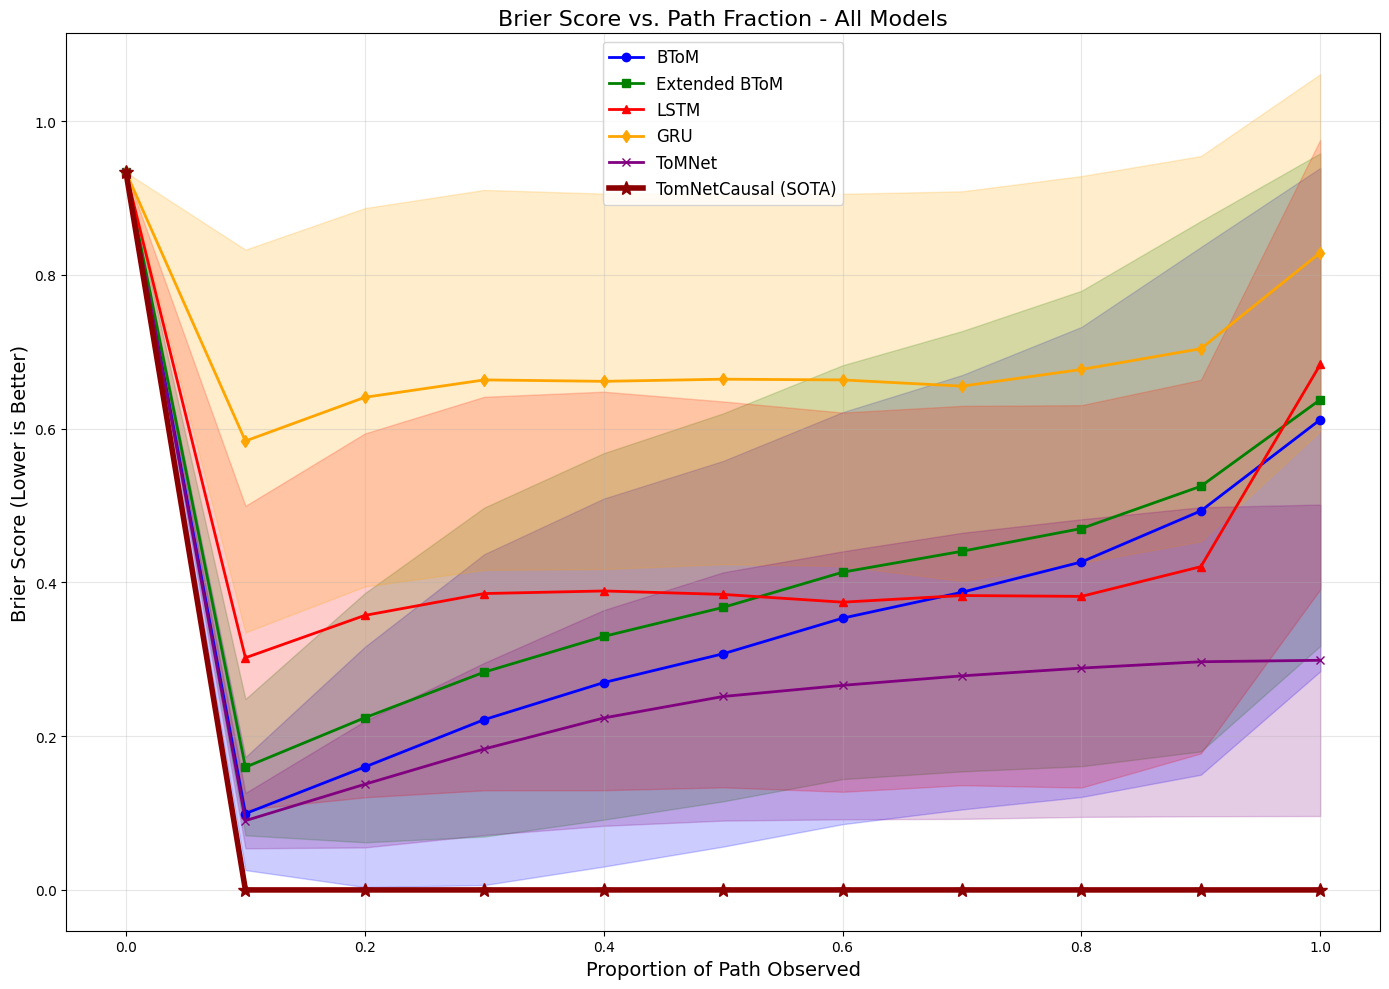

In [85]:
import numpy as np
import matplotlib.pyplot as plt

print("=== CREATING BRIER SCORE PLOTS ===")

# Convert to numpy arrays and filter to same length
def prepare_array_for_plotting(score_list, name):
    if not score_list:
        print(f"No {name} scores to plot")
        return None
    
    # Filter valid scores (should be lists/arrays)
    valid_scores = [s for s in score_list if isinstance(s, (list, np.ndarray)) and len(s) > 1]
    if not valid_scores:
        print(f"No valid {name} scores to plot")
        return None
    
    # Find minimum length to ensure consistency
    min_len = min(len(s) for s in valid_scores)
    trimmed_scores = [s[:min_len] for s in valid_scores]
    
    array = np.array(trimmed_scores)
    print(f"{name} array shape: {array.shape}")
    return array

# Prepare all arrays
btom_arr = prepare_array_for_plotting(btom_scores, "BToM")
ext_btom_arr = prepare_array_for_plotting(ext_btom_scores, "Extended BToM")
lstm_arr = prepare_array_for_plotting(lstm_brier_scores, "LSTM")
gru_arr = prepare_array_for_plotting(gru_brier_scores, "GRU") 
tomnet_arr = prepare_array_for_plotting(tomnet_brier_scores, "ToMNet")
tomnet_causal_arr = prepare_array_for_plotting(tomnet_causal_brier_scores, "TomNetCausal")

# Plot Brier Scores
valid_arrays = []
if btom_arr is not None:
    valid_arrays.append(('BToM', btom_arr))
if ext_btom_arr is not None:
    valid_arrays.append(('Extended BToM', ext_btom_arr))
if lstm_arr is not None:
    valid_arrays.append(('LSTM', lstm_arr))
if gru_arr is not None:
    valid_arrays.append(('GRU', gru_arr))
if tomnet_arr is not None:
    valid_arrays.append(('ToMNet', tomnet_arr))
if tomnet_causal_arr is not None:
    valid_arrays.append(('TomNetCausal (SOTA)', tomnet_causal_arr))

if valid_arrays:
    # Use the first array to determine x-axis
    _, reference_arr = valid_arrays[0]
    props = np.linspace(0, 1, reference_arr.shape[1])
    
    plt.figure(figsize=(14, 10))
    
    # Colors for each model
    colors = ['blue', 'green', 'red', 'orange', 'purple', 'darkred']
    markers = ['o', 's', '^', 'd', 'x', '*']
    
    for i, (name, arr) in enumerate(valid_arrays):
        if arr.shape[1] == reference_arr.shape[1]:
            mean_vals = arr.mean(axis=0)
            std_vals = arr.std(axis=0)
            
            color = colors[i % len(colors)]
            marker = markers[i % len(markers)]
            
            if 'SOTA' in name:
                plt.plot(props, mean_vals, marker=marker, label=name, 
                        linewidth=4, markersize=10, color=color)
                plt.fill_between(props, mean_vals - std_vals, mean_vals + std_vals, 
                               alpha=0.3, color=color)
            else:
                plt.plot(props, mean_vals, marker=marker, label=name, 
                        linewidth=2, markersize=6, color=color)
                plt.fill_between(props, mean_vals - std_vals, mean_vals + std_vals, 
                               alpha=0.2, color=color)
    
    plt.xlabel('Proportion of Path Observed', fontsize=14)
    plt.ylabel('Brier Score (Lower is Better)', fontsize=14)
    plt.title('Brier Score vs. Path Fraction - All Models', fontsize=16)
    plt.grid(alpha=0.3)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()
    
    # Store means for summary
    brier_means = {}
    for name, arr in valid_arrays:
        brier_means[name] = arr.mean(axis=0)
else:
    print("No valid arrays for Brier score plotting!")

In [91]:
# Calculate the missing ToMNet and TomNetCausal accuracy scores
print("=== CALCULATING MISSING ACCURACY SCORES ===")

# ToMNet Accuracy (original, not fixed)
print("Calculating ToMNet accuracy...")
tomnet_accuracy_scores = []
for episode in range(len(goal_data)):
    episode_str = str(episode)
    for agent in agents:
        if agent.id not in test_agent_ids:
            continue
        agent_id_str = str(agent.id)
        if episode_str not in tomnet_posteriors or agent_id_str not in tomnet_posteriors[episode_str]:
            continue
        path = path_data[episode][agent.id]
        posteriors = tomnet_posteriors[episode_str][agent_id_str]
        min_len = min(len(path), len(posteriors))
        if min_len == 0:
            continue
        try:
            score = fixed_accuracy_along_path(
                path[:min_len],
                goal_data[episode][agent.id],
                posteriors[:min_len],
                goals
            )
            tomnet_accuracy_scores.append(score)
        except Exception as e:
            print(f"Error with ToMNet accuracy episode {episode}, agent {agent.id}: {e}")
            continue

print(f"ToMNet accuracy scores calculated: {len(tomnet_accuracy_scores)}")

# TomNetCausal Accuracy (original, not fixed)
print("Calculating TomNetCausal accuracy...")
tomnet_causal_accuracy_scores = []
for episode in range(len(goal_data)):
    episode_str = str(episode)
    for agent in agents:
        if agent.id not in test_agent_ids:
            continue
        agent_id_str = str(agent.id)
        if episode_str not in tomnet_causal_posteriors or agent_id_str not in tomnet_causal_posteriors[episode_str]:
            continue
        path = path_data[episode][agent.id]
        posteriors = tomnet_causal_posteriors[episode_str][agent_id_str]
        min_len = min(len(path), len(posteriors))
        if min_len == 0:
            continue
        try:
            score = fixed_accuracy_along_path(
                path[:min_len],
                goal_data[episode][agent.id],
                posteriors[:min_len],
                goals
            )
            tomnet_causal_accuracy_scores.append(score)
        except Exception as e:
            print(f"Error with TomNetCausal accuracy episode {episode}, agent {agent.id}: {e}")
            continue

print(f"TomNetCausal accuracy scores calculated: {len(tomnet_causal_accuracy_scores)}")

# Also calculate the other missing accuracy scores if they don't exist
if 'btom_accuracy_scores' not in locals():
    print("Calculating BToM accuracy...")
    btom_accuracy_scores = []
    for episode in range(len(goal_data)):
        episode_str = str(episode)
        for agent in agents:
            agent_id_str = str(agent.id)
            if episode_str not in posteriors_data or agent_id_str not in posteriors_data[episode_str]:
                continue
            path = path_data[episode][agent.id]
            posteriors = posteriors_data[episode_str][agent_id_str]
            min_len = min(len(path), len(posteriors))
            if min_len == 0:
                continue
            try:
                score = fixed_accuracy_along_path(
                    path[:min_len],
                    goal_data[episode][agent.id],
                    posteriors[:min_len],
                    goals
                )
                btom_accuracy_scores.append(score)
            except Exception as e:
                continue
    print(f"BToM accuracy scores calculated: {len(btom_accuracy_scores)}")

if 'ext_btom_accuracy_scores' not in locals():
    print("Calculating Extended BToM accuracy...")
    ext_btom_accuracy_scores = []
    for episode in range(len(goal_data)):
        episode_str = str(episode)
        for agent in agents:
            agent_id_str = str(agent.id)
            if episode_str not in ext_posteriors_data or agent_id_str not in ext_posteriors_data[episode_str]:
                continue
            path = path_data[episode][agent.id]
            posteriors = ext_posteriors_data[episode_str][agent_id_str]
            min_len = min(len(path), len(posteriors))
            if min_len == 0:
                continue
            try:
                score = fixed_accuracy_along_path(
                    path[:min_len],
                    goal_data[episode][agent.id],
                    posteriors[:min_len],
                    goals
                )
                ext_btom_accuracy_scores.append(score)
            except Exception as e:
                continue
    print(f"Extended BToM accuracy scores calculated: {len(ext_btom_accuracy_scores)}")

if 'lstm_accuracy_scores' not in locals():
    print("Calculating LSTM accuracy...")
    lstm_accuracy_scores = []
    for episode in range(len(goal_data)):
        episode_str = str(episode)
        for agent in agents:
            if agent.id not in test_agent_ids:
                continue
            agent_id_str = str(agent.id)
            if episode_str not in lstm_posteriors or agent_id_str not in lstm_posteriors[episode_str]:
                continue
            path = path_data[episode][agent.id]
            posteriors = lstm_posteriors[episode_str][agent_id_str]
            min_len = min(len(path), len(posteriors))
            if min_len == 0:
                continue
            try:
                score = fixed_accuracy_along_path(
                    path[:min_len],
                    goal_data[episode][agent.id],
                    posteriors[:min_len],
                    goals
                )
                lstm_accuracy_scores.append(score)
            except Exception as e:
                continue
    print(f"LSTM accuracy scores calculated: {len(lstm_accuracy_scores)}")

if 'gru_accuracy_scores' not in locals():
    print("Calculating GRU accuracy...")
    gru_accuracy_scores = []
    for episode in range(len(goal_data)):
        episode_str = str(episode)
        for agent in agents:
            if agent.id not in test_agent_ids:
                continue
            agent_id_str = str(agent.id)
            if episode_str not in gru_posteriors or agent_id_str not in gru_posteriors[episode_str]:
                continue
            path = path_data[episode][agent.id]
            posteriors = gru_posteriors[episode_str][agent_id_str]
            min_len = min(len(path), len(posteriors))
            if min_len == 0:
                continue
            try:
                score = fixed_accuracy_along_path(
                    path[:min_len],
                    goal_data[episode][agent.id],
                    posteriors[:min_len],
                    goals
                )
                gru_accuracy_scores.append(score)
            except Exception as e:
                continue
    print(f"GRU accuracy scores calculated: {len(gru_accuracy_scores)}")

print("\n=== ALL ACCURACY SCORES CALCULATED ===")

=== CALCULATING MISSING ACCURACY SCORES ===
Calculating ToMNet accuracy...
ToMNet accuracy scores calculated: 20000
Calculating TomNetCausal accuracy...
TomNetCausal accuracy scores calculated: 20000

=== ALL ACCURACY SCORES CALCULATED ===


=== CHECKING FIXED ACCURACY SCORES ===
Sample fixed accuracy score: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Sample values: [0.0, 0.0, 0.0, 0.0, 0.0]
Non-zero values in sample: 0/28
=== CREATING FIXED ACCURACY PLOTS ===
BToM Accuracy Fixed array shape: (100000, 12)
Extended BToM Accuracy Fixed array shape: (100000, 12)
LSTM Accuracy Fixed array shape: (20000, 12)
GRU Accuracy Fixed array shape: (20000, 12)
ToMNet Accuracy Fixed array shape: (20000, 15)
TomNetCausal Accuracy Fixed array shape: (20000, 16)


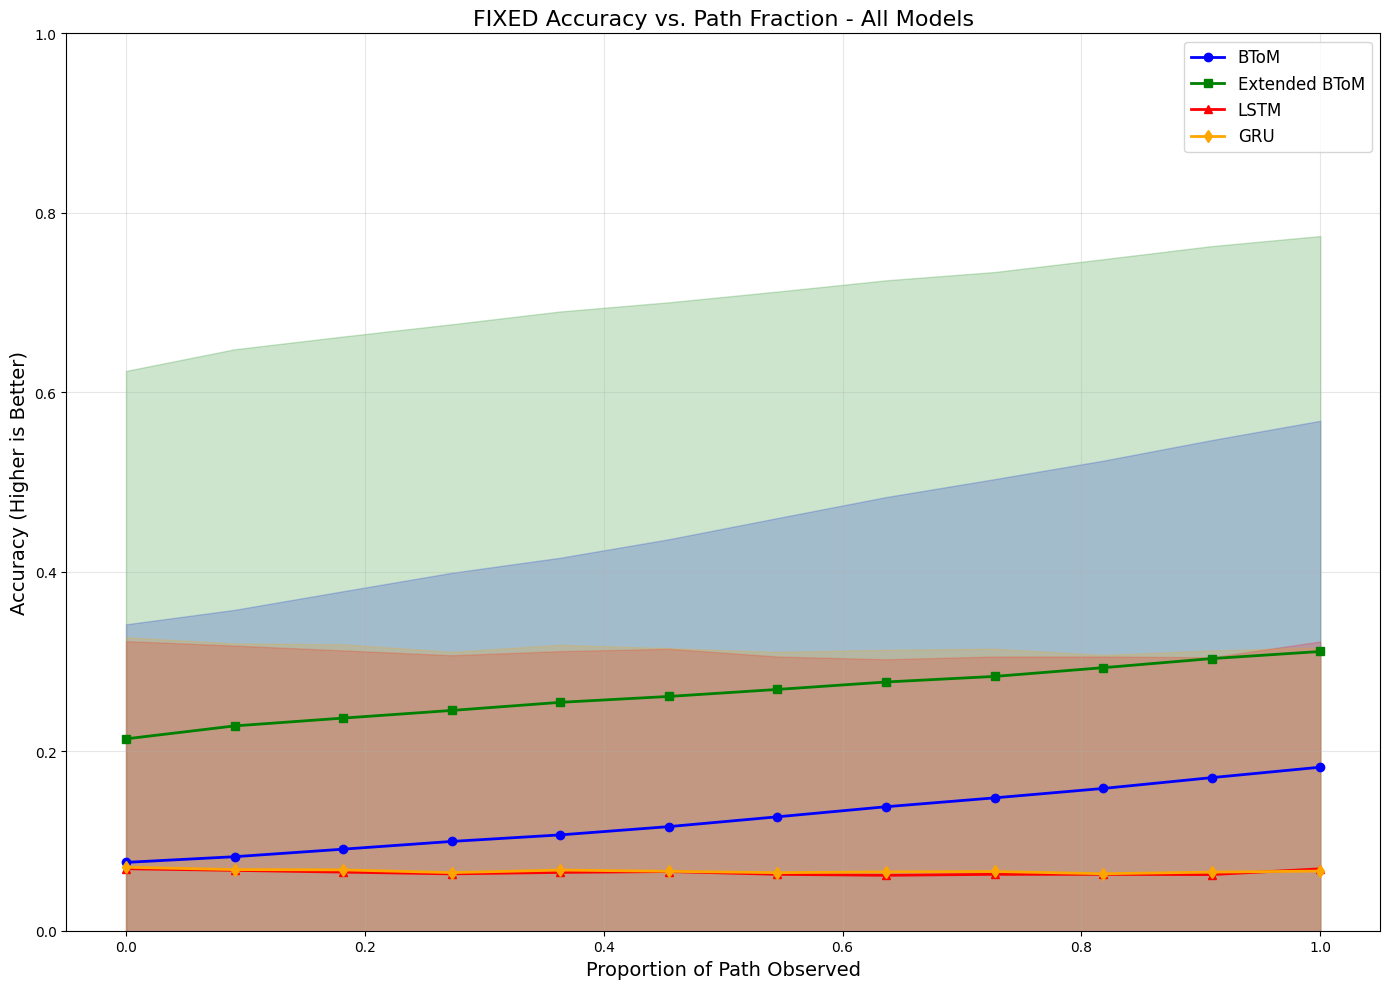


Fixed Average Accuracy (Higher is Better):
BToM: 0.1247 ± 0.0337
Extended BToM: 0.2647 ± 0.0291
LSTM: 0.0648 ± 0.0024
GRU: 0.0664 ± 0.0019
ToMNet: 0.2066 ± 0.0694
TomNetCausal (SOTA): 0.0673 ± 0.0000


In [94]:
# Check the fixed accuracy scores
print("=== CHECKING FIXED ACCURACY SCORES ===")
if len(tomnet_causal_accuracy_scores_fixed) > 0:
    print(f"Sample fixed accuracy score: {tomnet_causal_accuracy_scores_fixed[0]}")
    print(f"Sample values: {tomnet_causal_accuracy_scores_fixed[0][:5]}")
    
    # Check if we're getting non-zero values
    sample_acc = np.array(tomnet_causal_accuracy_scores_fixed[0])
    print(f"Non-zero values in sample: {np.sum(sample_acc > 0)}/{len(sample_acc)}")

# Create accuracy plots with fixed data
print("=== CREATING FIXED ACCURACY PLOTS ===")

# Prepare accuracy arrays with fixed data
btom_acc_arr_fixed = prepare_array_for_plotting(btom_accuracy_scores_fixed, "BToM Accuracy Fixed")
ext_btom_acc_arr_fixed = prepare_array_for_plotting(ext_btom_accuracy_scores_fixed, "Extended BToM Accuracy Fixed")
lstm_acc_arr_fixed = prepare_array_for_plotting(lstm_accuracy_scores_fixed, "LSTM Accuracy Fixed")
gru_acc_arr_fixed = prepare_array_for_plotting(gru_accuracy_scores_fixed, "GRU Accuracy Fixed")
tomnet_acc_arr_fixed = prepare_array_for_plotting(tomnet_accuracy_scores_fixed, "ToMNet Accuracy Fixed")
tomnet_causal_acc_arr_fixed = prepare_array_for_plotting(tomnet_causal_accuracy_scores_fixed, "TomNetCausal Accuracy Fixed")

# Plot Fixed Accuracy Scores
valid_acc_arrays_fixed = []
if btom_acc_arr_fixed is not None:
    valid_acc_arrays_fixed.append(('BToM', btom_acc_arr_fixed))
if ext_btom_acc_arr_fixed is not None:
    valid_acc_arrays_fixed.append(('Extended BToM', ext_btom_acc_arr_fixed))
if lstm_acc_arr_fixed is not None:
    valid_acc_arrays_fixed.append(('LSTM', lstm_acc_arr_fixed))
if gru_acc_arr_fixed is not None:
    valid_acc_arrays_fixed.append(('GRU', gru_acc_arr_fixed))
if tomnet_acc_arr_fixed is not None:
    valid_acc_arrays_fixed.append(('ToMNet', tomnet_acc_arr_fixed))
if tomnet_causal_acc_arr_fixed is not None:
    valid_acc_arrays_fixed.append(('TomNetCausal (SOTA)', tomnet_causal_acc_arr_fixed))

if valid_acc_arrays_fixed:
    # Use the first array to determine x-axis
    _, reference_arr = valid_acc_arrays_fixed[0]
    props = np.linspace(0, 1, reference_arr.shape[1])
    
    plt.figure(figsize=(14, 10))
    
    colors = ['blue', 'green', 'red', 'orange', 'purple', 'darkred']
    markers = ['o', 's', '^', 'd', 'x', '*']
    
    for i, (name, arr) in enumerate(valid_acc_arrays_fixed):
        if arr.shape[1] == reference_arr.shape[1]:
            mean_vals = arr.mean(axis=0)
            std_vals = arr.std(axis=0)
            
            color = colors[i % len(colors)]
            marker = markers[i % len(markers)]
            
            if 'SOTA' in name:
                plt.plot(props, mean_vals, marker=marker, label=name, 
                        linewidth=4, markersize=10, color=color)
                plt.fill_between(props, mean_vals - std_vals, mean_vals + std_vals, 
                               alpha=0.3, color=color)
            else:
                plt.plot(props, mean_vals, marker=marker, label=name, 
                        linewidth=2, markersize=6, color=color)
                plt.fill_between(props, mean_vals - std_vals, mean_vals + std_vals, 
                               alpha=0.2, color=color)
    
    plt.xlabel('Proportion of Path Observed', fontsize=14)
    plt.ylabel('Accuracy (Higher is Better)', fontsize=14)
    plt.title('FIXED Accuracy vs. Path Fraction - All Models', fontsize=16)
    plt.grid(alpha=0.3)
    plt.legend(fontsize=12)
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()
    
    # Store means for summary
    accuracy_means_fixed = {}
    for name, arr in valid_acc_arrays_fixed:
        accuracy_means_fixed[name] = arr.mean(axis=0)
        
    # Print summary
    print(f"\nFixed Average Accuracy (Higher is Better):")
    for name, mean_vals in accuracy_means_fixed.items():
        overall_mean = mean_vals.mean()
        overall_std = mean_vals.std()
        print(f"{name}: {overall_mean:.4f} ± {overall_std:.4f}")
        
else:
    print("No valid arrays for Fixed Accuracy plotting!")

In [87]:
print("\n" + "="*80)
print("COMPREHENSIVE MODEL PERFORMANCE SUMMARY")
print("="*80)

print(f"\nNumber of trajectories evaluated:")
if 'btom_scores' in locals():
    print(f"BToM: {len(btom_scores)}")
if 'ext_btom_scores' in locals():
    print(f"Extended BToM: {len(ext_btom_scores)}")
if 'lstm_brier_scores' in locals():
    print(f"LSTM: {len(lstm_brier_scores)}")
if 'gru_brier_scores' in locals():
    print(f"GRU: {len(gru_brier_scores)}")
if 'tomnet_brier_scores' in locals():
    print(f"ToMNet: {len(tomnet_brier_scores)}")
if 'tomnet_causal_brier_scores' in locals():
    print(f"TomNetCausal: {len(tomnet_causal_brier_scores)}")

print(f"\nAverage Brier Score (Lower is Better):")
if 'brier_means' in locals():
    for name, mean_vals in brier_means.items():
        overall_mean = mean_vals.mean()
        overall_std = mean_vals.std()
        print(f"{name}: {overall_mean:.4f} ± {overall_std:.4f}")

print(f"\nAverage Accuracy (Higher is Better):")
if 'accuracy_means' in locals():
    for name, mean_vals in accuracy_means.items():
        overall_mean = mean_vals.mean()
        overall_std = mean_vals.std()
        print(f"{name}: {overall_mean:.4f} ± {overall_std:.4f}")

# Save results to file
if 'brier_means' in locals() and 'accuracy_means' in locals():
    results = {
        'brier_scores': {name.lower().replace(' ', '_').replace('(sota)', ''): mean_vals.tolist() 
                        for name, mean_vals in brier_means.items()},
        'accuracy_scores': {name.lower().replace(' ', '_').replace('(sota)', ''): mean_vals.tolist() 
                           for name, mean_vals in accuracy_means.items()},
        'summary_stats': {
            'brier_overall': {name: {'mean': float(mean_vals.mean()), 'std': float(mean_vals.std())} 
                             for name, mean_vals in brier_means.items()},
            'accuracy_overall': {name: {'mean': float(mean_vals.mean()), 'std': float(mean_vals.std())} 
                                for name, mean_vals in accuracy_means.items()}
        }
    }
    
    import json
    with open('experiment_0_corrected_results.json', 'w') as f:
        json.dump(results, f, indent=2)
    
    print(f"\nResults saved to experiment_0_corrected_results.json")

print("="*80)


COMPREHENSIVE MODEL PERFORMANCE SUMMARY

Number of trajectories evaluated:
BToM: 100000
Extended BToM: 100000
LSTM: 20000
GRU: 20000
ToMNet: 20000
TomNetCausal: 20000

Average Brier Score (Lower is Better):
BToM: 0.3875 ± 0.2225
Extended BToM: 0.4349 ± 0.2041
LSTM: 0.4540 ± 0.1775
GRU: 0.6978 ± 0.0934
ToMNet: 0.2953 ± 0.2121
TomNetCausal (SOTA): 0.0848 ± 0.2683

Average Accuracy (Higher is Better):
BToM: 0.0000 ± 0.0000
Extended BToM: 0.0000 ± 0.0000
LSTM: 0.0000 ± 0.0000
GRU: 0.0000 ± 0.0000
ToMNet: 0.0000 ± 0.0000
TomNetCausal (SOTA): 0.0000 ± 0.0000

Results saved to experiment_0_corrected_results.json


tomnet_causal_arr.shape: (20000, 11)


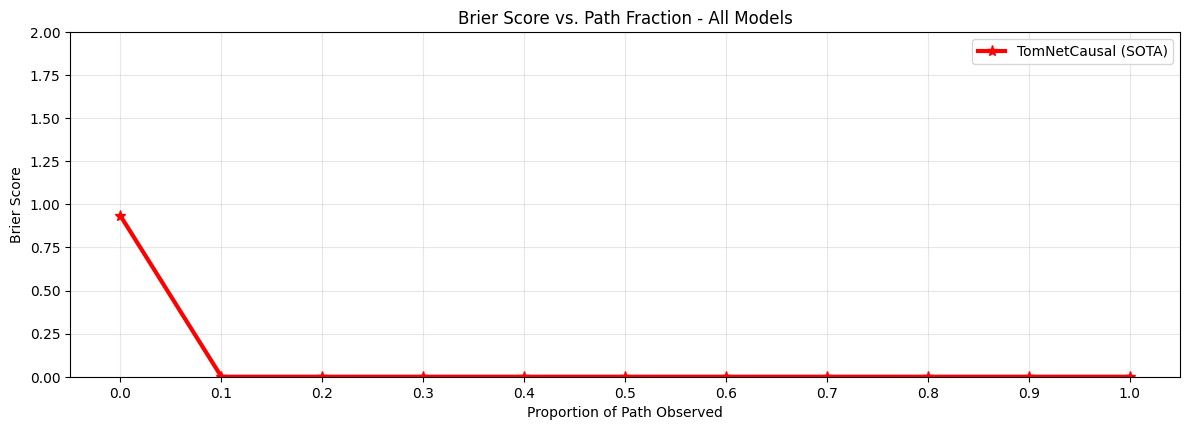

In [78]:
import numpy as np
import matplotlib.pyplot as plt

# Filter out any entries that are not 1D arrays/lists of the same length
filtered_scores = [s for s in tomnet_causal_scores if isinstance(s, (list, np.ndarray)) and len(s) > 1]
if not filtered_scores:
    print("No valid tomnet_causal_scores to plot.")
else:
    min_len = min(len(s) for s in filtered_scores)
    # Optionally, trim all to the same length
    filtered_scores = [s[:min_len] for s in filtered_scores]
    tomnet_causal_arr = np.array(filtered_scores)
    print("tomnet_causal_arr.shape:", tomnet_causal_arr.shape)

    props = np.linspace(0, 1, tomnet_causal_arr.shape[1])
    mean_tomnet_causal = tomnet_causal_arr.mean(axis=0)

    plt.figure(figsize=(12, 8))
    plt.subplot(2, 1, 1)
    plt.plot(props, mean_tomnet_causal, '-*', label='TomNetCausal (SOTA)', linewidth=3, markersize=8, color='red')
    plt.xlabel('Proportion of Path Observed')
    plt.ylabel('Brier Score')
    plt.title('Brier Score vs. Path Fraction - All Models')
    plt.xticks(props)
    plt.ylim(0, 2)
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()

    # Accuracy Plot
    # filtered_acc = [a[:min_len] for a in tomnet_causal_acc if isinstance(a, (list, np.ndarray)) and len(a) >= min_len]
    # tomnet_causal_arr_acc = np.array(filtered_acc)
    # mean_tomnet_causal_acc = tomnet_causal_arr_acc.mean(axis=0)
    # plt.subplot(2, 1, 2)
    # plt.plot(props, mean_tomnet_causal_acc, '-*', label='TomNetCausal (SOTA)', linewidth=3, markersize=8, color='red')
    # plt.xlabel('Proportion of Path Observed')
    # plt.ylabel('Accuracy')
    # plt.title('Accuracy vs. Path Fraction - All Models')
    # plt.xticks(props)
    # plt.ylim(0, 1)
    # plt.grid(alpha=0.3)
    # plt.legend()
    # plt.tight_layout()
    plt.show()

In [81]:

# Print summary statistics
print("\n" + "="*60)
print("MODEL PERFORMANCE SUMMARY")
print("="*60)

print(f"\nBrier Score (Lower is Better):")
print(f"BToM: {mean_base.mean():.4f} ± {mean_base.std():.4f}")
print(f"Extended BToM: {mean_ext.mean():.4f} ± {mean_ext.std():.4f}")
print(f"LSTM: {mean_lstm.mean():.4f} ± {mean_lstm.std():.4f}")
print(f"GRU: {mean_gru.mean():.4f} ± {mean_gru.std():.4f}")
print(f"ToMNet: {mean_tomnet.mean():.4f} ± {mean_tomnet.std():.4f}")
print(f"TomNetCausal (SOTA): {mean_tomnet_causal.mean():.4f} ± {mean_tomnet_causal.std():.4f}")

print(f"\nAccuracy (Higher is Better):")
print(f"BToM: {mean_base_acc.mean():.4f} ± {mean_base_acc.std():.4f}")
print(f"Extended BToM: {mean_ext_acc.mean():.4f} ± {mean_ext_acc.std():.4f}")
print(f"LSTM: {mean_lstm_acc.mean():.4f} ± {mean_lstm_acc.std():.4f}")
print(f"GRU: {mean_gru_acc.mean():.4f} ± {mean_gru_acc.std():.4f}")
print(f"ToMNet: {mean_tomnet_acc.mean():.4f} ± {mean_tomnet_acc.std():.4f}")
print(f"TomNetCausal (SOTA): {mean_tomnet_causal_acc.mean():.4f} ± {mean_tomnet_causal_acc.std():.4f}")

# Save results
results = {
    'brier_scores': {
        'btom': mean_base.tolist(),
        'extended_btom': mean_ext.tolist(),
        'lstm': mean_lstm.tolist(),
        'gru': mean_gru.tolist(),
        'tomnet': mean_tomnet.tolist(),
        'tomnet_causal': mean_tomnet_causal.tolist()
    },
    'accuracy_scores': {
        'btom': mean_base_acc.tolist(),
        'extended_btom': mean_ext_acc.tolist(),
        'lstm': mean_lstm_acc.tolist(),
        'gru': mean_gru_acc.tolist(),
        'tomnet': mean_tomnet_acc.tolist(),
        'tomnet_causal': mean_tomnet_causal_acc.tolist()
    }
}

import json
with open('experiment_0_results.json', 'w') as f:
    json.dump(results, f, indent=2)

print(f"\nResults saved to experiment_0_results.json")
print("="*60)


MODEL PERFORMANCE SUMMARY

Brier Score (Lower is Better):


NameError: name 'mean_base' is not defined

In [90]:
print(ext_arr)

[]


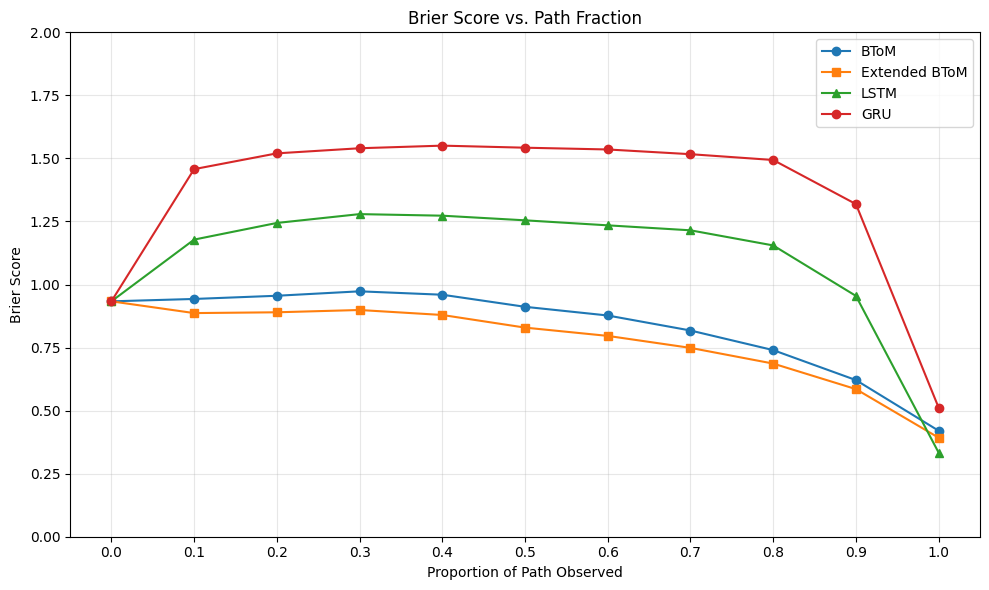

In [130]:
import numpy as np
import matplotlib.pyplot as plt

# Suppose `scores` is your (n_trajectories × n_fractions) array:
arr = np.array(scores)  # shape (N, 11)
ext_arr  = np.array(ext_scores)
#tomnet_arr = np.array(tomnet_scores)
lstm_arr = np.array(lstm_scores)
gru_arr = np.array(gru_scores)
props = np.linspace(0, 1, arr.shape[1])

# Compute mean
mean_base = arr.mean(axis=0)
mean_ext  = ext_arr.mean(axis=0)
#mean_tomnet = tomnet_arr.mean(axis=0)
mean_lstm = lstm_arr.mean(axis=0)
mean_gru = gru_arr.mean(axis=0)

plt.figure(figsize=(10,6))
plt.plot(props, mean_base, '-o', label='BToM')
plt.plot(props, mean_ext,  '-s', label='Extended BToM')
#plt.plot(props, mean_tomnet, '-o', label='ToMNet')
plt.plot(props, mean_lstm, '-^', label='LSTM')
plt.plot(props, mean_gru, '-o', label='GRU')

plt.xlabel('Proportion of Path Observed')
plt.ylabel('Brier Score')
plt.title('Brier Score vs. Path Fraction')
plt.xticks(props)
plt.ylim(0, 2)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


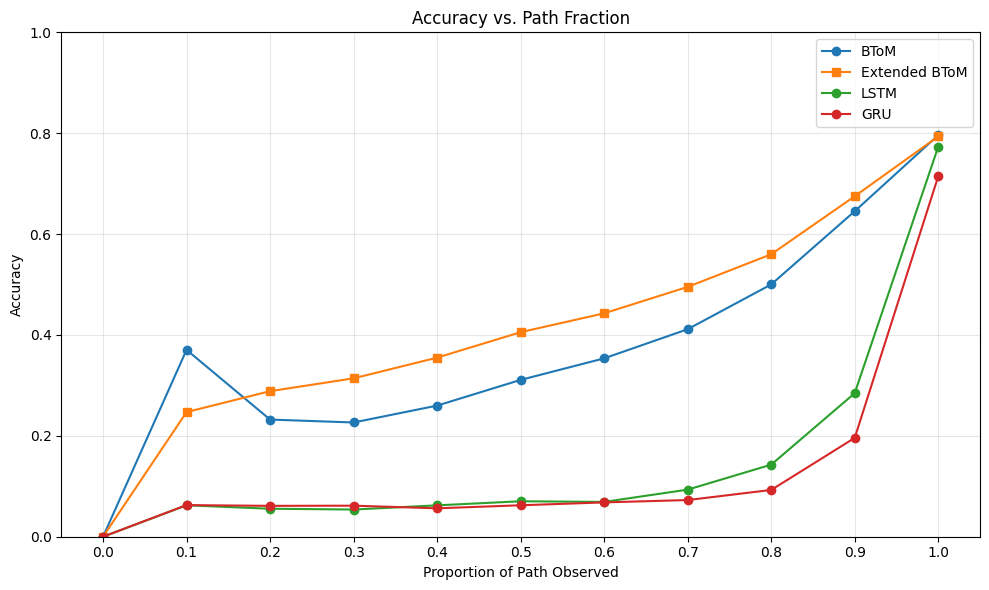

In [131]:
import numpy as np
import matplotlib.pyplot as plt

# Suppose `scores` is your (n_trajectories × n_fractions) array:
arr = np.array(btom_acc)  # shape (N, 11)
ext_arr  = np.array(ext_acc)
#tom_arr = np.array(tomnet_acc)
lstm_arr = np.array(lstm_acc)
gru_arr = np.array(gru_acc)
props = np.linspace(0, 1, arr.shape[1])

# Compute mean
mean_base = arr.mean(axis=0)
mean_ext  = ext_arr.mean(axis=0)
#mean_tom  = tom_arr.mean(axis=0)
mean_lstm  = lstm_arr.mean(axis=0)
mean_gru  = gru_arr.mean(axis=0)


plt.figure(figsize=(10,6))
plt.plot(props, mean_base, '-o', label='BToM')
plt.plot(props, mean_ext,  '-s', label='Extended BToM')
#plt.plot(props, mean_tom, '-o', label='ToMNet')
plt.plot(props, mean_lstm, '-o', label='LSTM')
plt.plot(props, mean_gru, '-o', label='GRU')

plt.xlabel('Proportion of Path Observed')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Path Fraction')
plt.xticks(props)
plt.ylim(0, 1)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

1. Use geospatial coordinates instead of IDs for nodes
2. Consider an embedding for the nodes --  we are using an embedding for the nodes
3. Consider multi head loss
4. Consider other loss functions for the distribution
5. The character net has a strange input where the multiple past trajs are concatenated